# Import packages

In [ ]:
# !pip install -r multiff_analysis/requirements.txt

In [120]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from non_behavioral_analysis.neural_data_analysis.model_neural_data import transform_vars, neural_data_modeling
from non_behavioral_analysis.neural_data_analysis.model_neural_data.cca_methods import cca_class, cca_utils, cca_lag_vs_no_lag_plotting, cca_cv_utils, cca_cv_plotting, cca_plotting
from non_behavioral_analysis.neural_data_analysis.decode_targets import decode_target_class, prep_decode_target
from data_wrangling import specific_utils, base_processing_class, general_utils

import sys

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import rcca

# To fit gpfa
import numpy as np
import neo
import matplotlib.pyplot as plt
from importlib import reload

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [3]:
reload(decode_target_class)

<module 'non_behavioral_analysis.neural_data_analysis.decode_targets.decode_target_class' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/non_behavioral_analysis/neural_data_analysis/decode_targets/decode_target_class.py'>

In [ ]:
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.02, window_width=0.05)
dec.get_x_and_y_data_for_modeling(exists_ok=True)

Loaded x_var from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_x_var.csv
Removing 7 columns with zero variance: ['unit_2', 'unit_7', 'unit_8', 'unit_10', 'unit_11', 'unit_12', 'unit_13']
Loaded y_var from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var.csv
Loaded y_var_reduced from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_reduced.csv
Loaded x_var_lags and y_var_lags from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_x_var_lags.csv and all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_lags.csv
Loaded x_var from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_x_var.csv
Removing 7 columns with zero variance: ['unit_2', 'unit_7', 'unit_8', 'unit_10', 'unit_11', 'unit_12', 'unit_13']
Loaded y_var from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var.csv
Loaded y_var_reduced from all_monkey_data/decoding_tar

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.15194 0.1254  0.10852 0.09002 0.07786 0.07004 0.06282 0.05899 0.05286
 0.04559]
% Shared Variance: [0.02309 0.01573 0.01178 0.0081  0.00606 0.00491 0.00395 0.00348 0.00279
 0.00208]


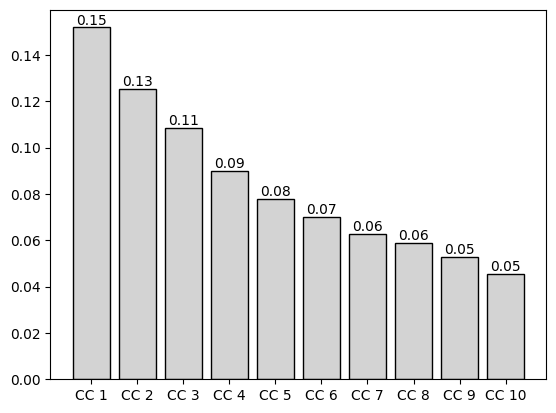

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.46219 0.35482 0.32576 0.25653 0.24745 0.22521 0.22387 0.21109 0.20718
 0.20351]
% Shared Variance: [0.21362 0.1259  0.10612 0.06581 0.06123 0.05072 0.05012 0.04456 0.04292
 0.04142]


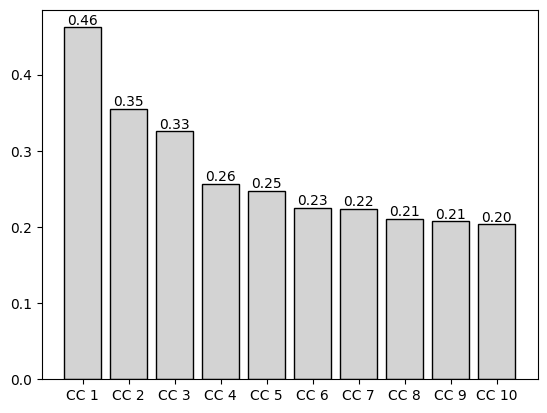

dec.x_var_lags.shape: (8507, 243)
dec.y_var_lags_reduced.shape: (8507, 87)


In [95]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var_reduced, X2=dec.y_var_reduced, lagging_included=False)
cca_no_lag.conduct_cca()

cca_lags = cca_class.CCAclass(X1=dec.x_var_lags_reduced.drop(columns='bin'), X2=dec.y_var_lags_reduced, lagging_included=True)
# for all columns that end with _0, rename them to the column name without the _0
cca_lags.X2.columns = cca_lags.X2.columns.str.replace('_0', '')
cca_lags.conduct_cca()


print(f'dec.x_var_lags.shape: {dec.x_var_lags.shape}')
print(f'dec.y_var_lags_reduced.shape: {dec.y_var_lags_reduced.shape}')

cca_inst = cca_lags

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## compare lag vs no lag

In [17]:
canon_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
canon_df[f'with_lags'] = cca_lags.canon_corr
canon_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert canon_df to long format
canon_df_long = pd.melt(canon_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

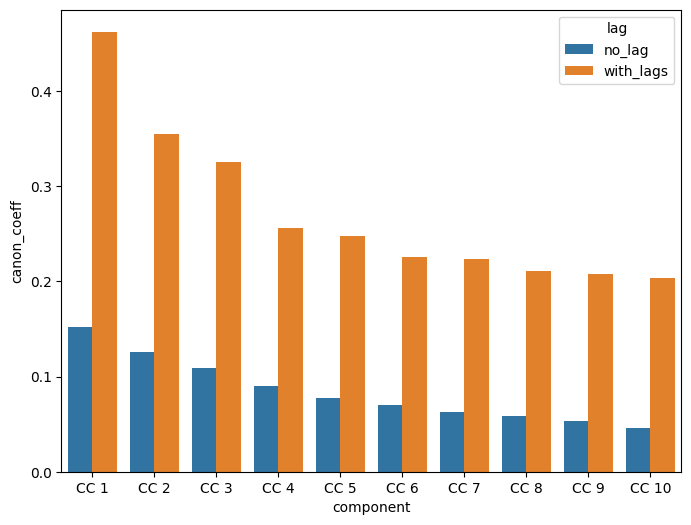

In [18]:
# make a sns bar plot on canon_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=canon_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [19]:
# choose no lag
cca_inst = cca_inst

In [20]:
# choose lags
cca_inst = cca_lags

# Barplots of loadings/weights

## loadings

### neurons

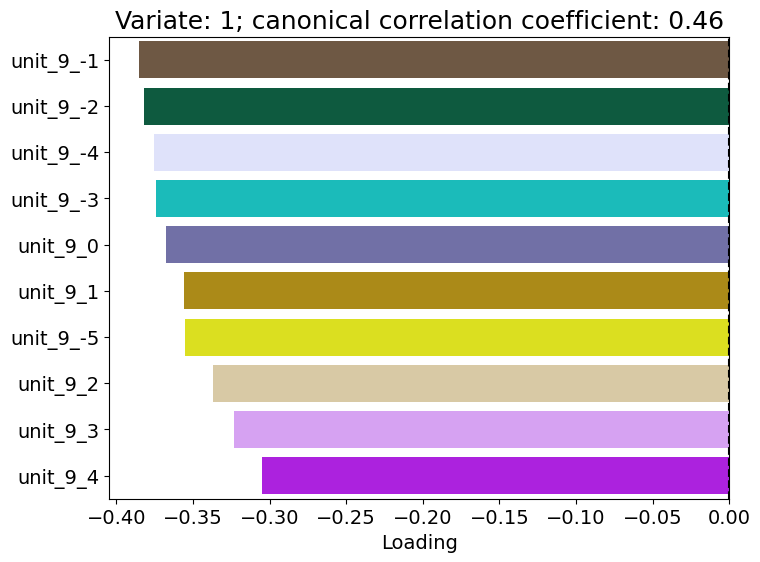

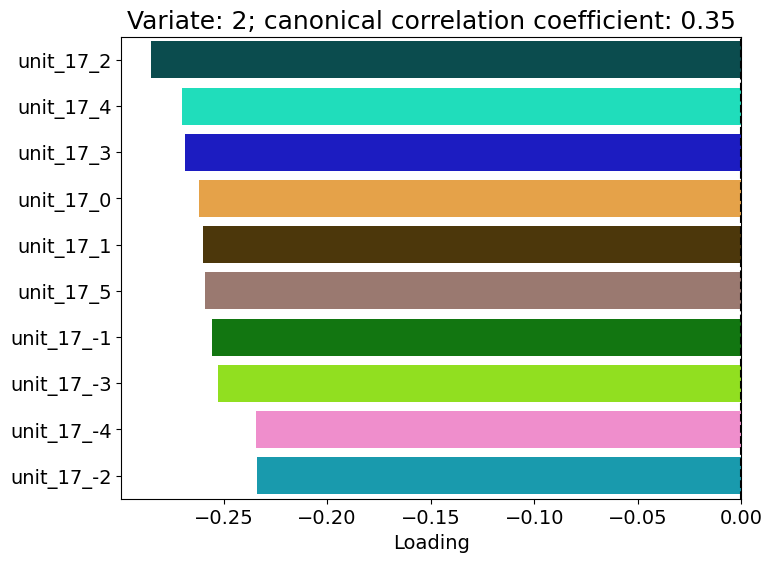

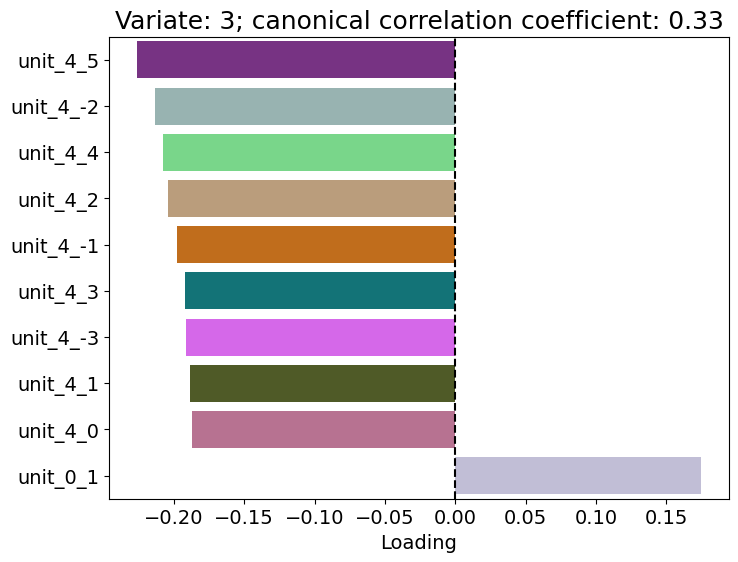

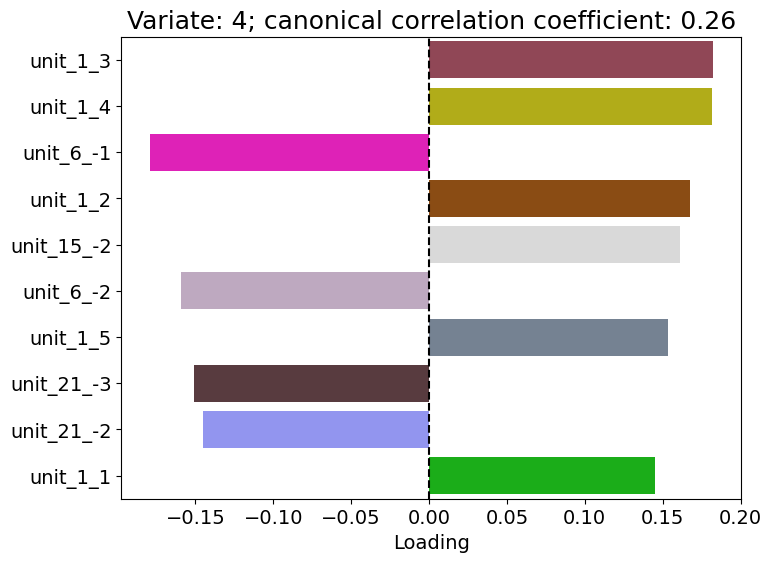

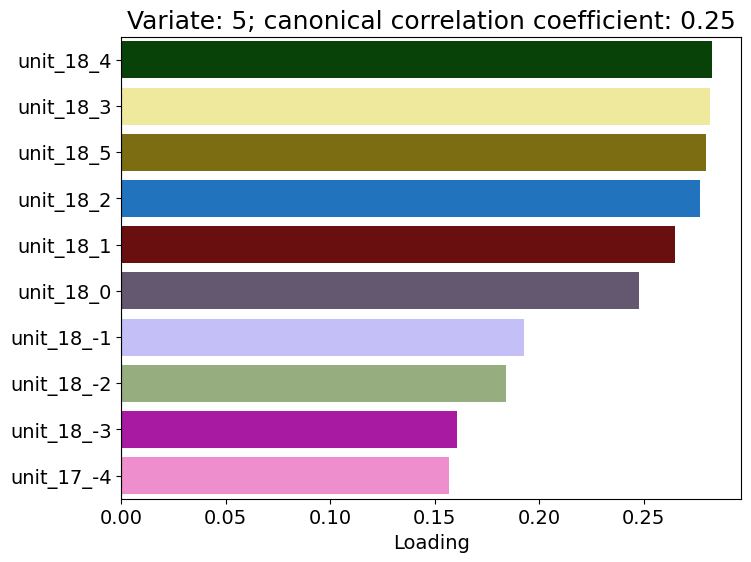

In [21]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

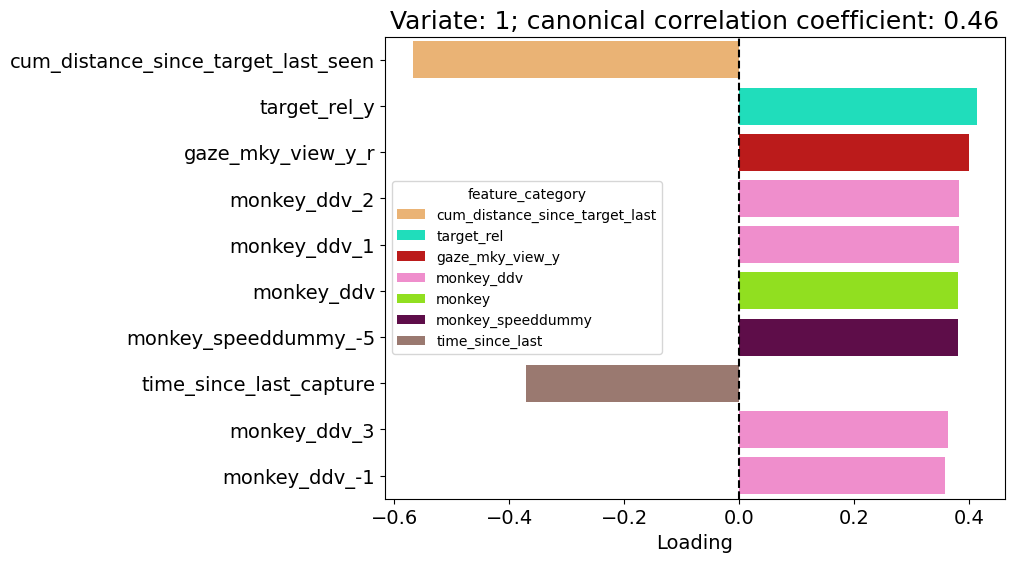

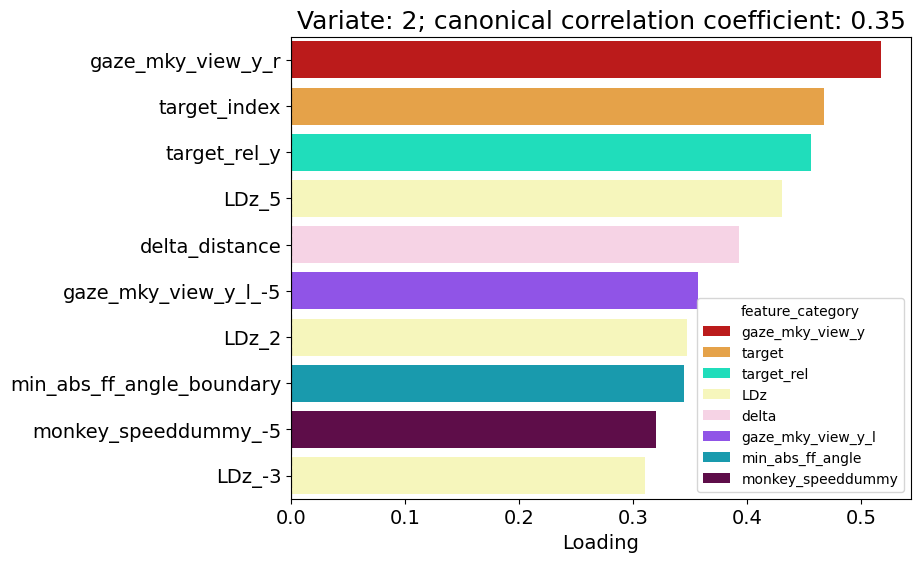

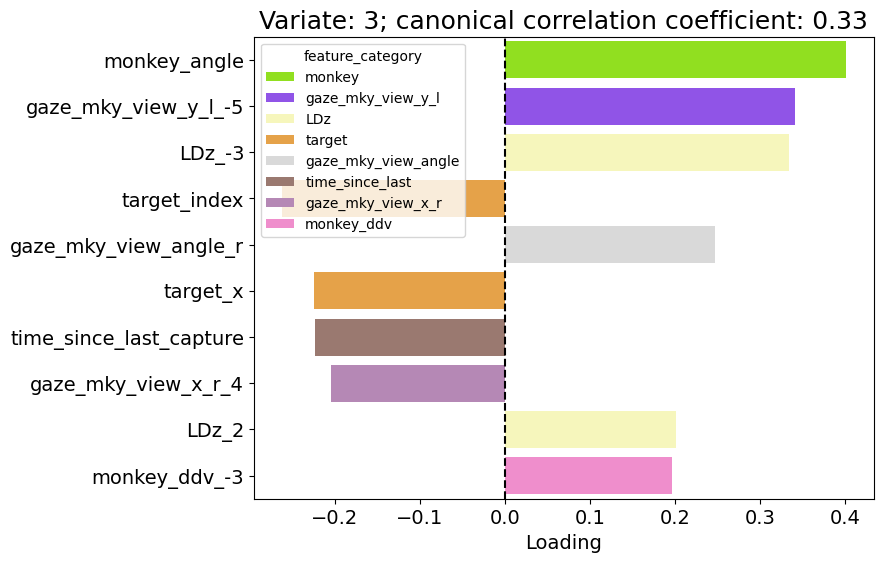

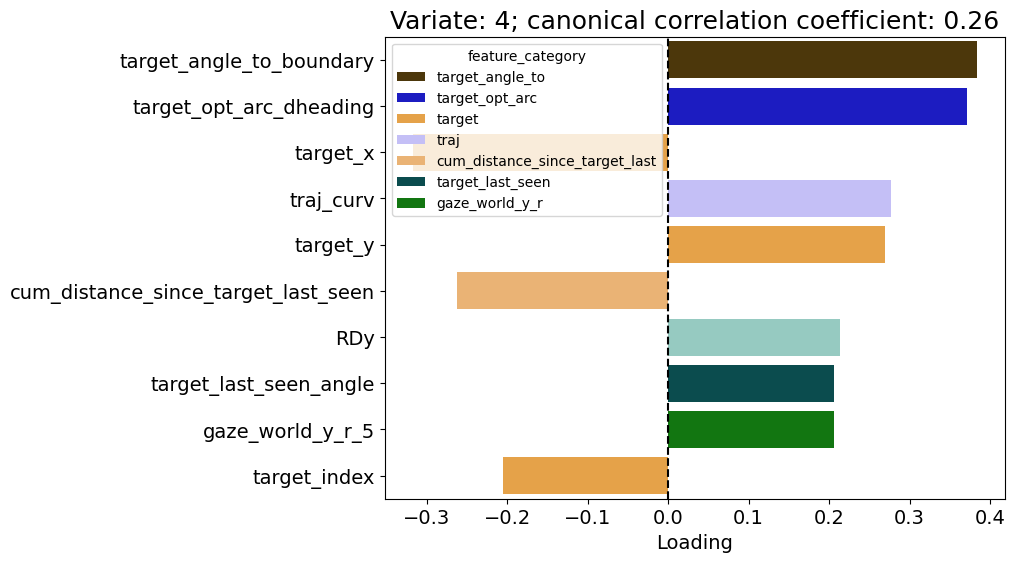

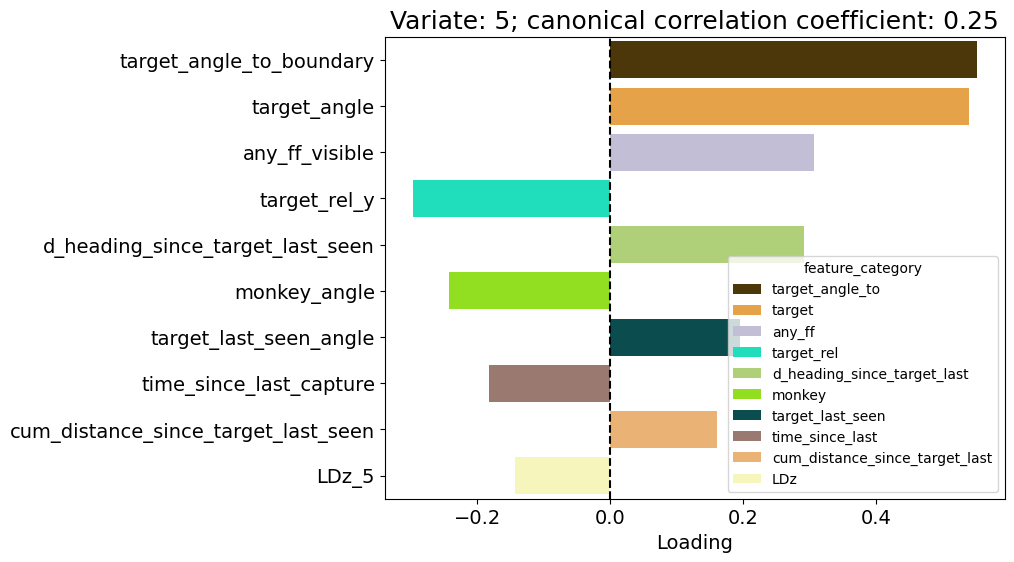

In [22]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

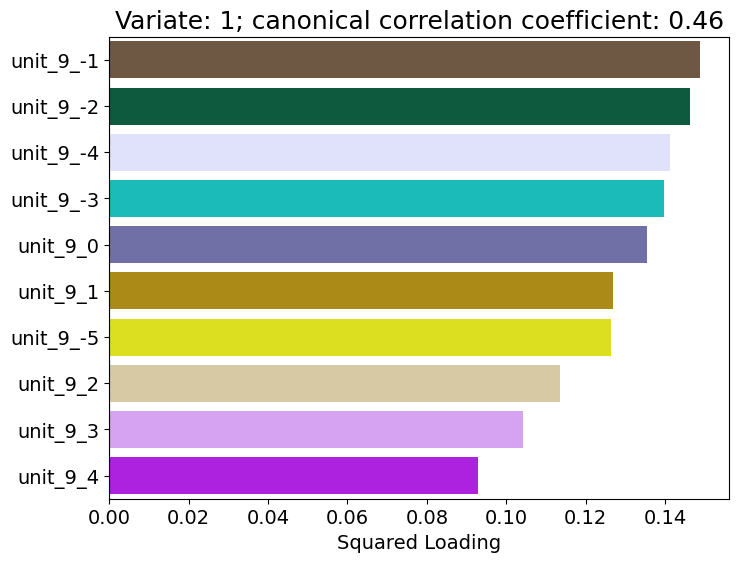

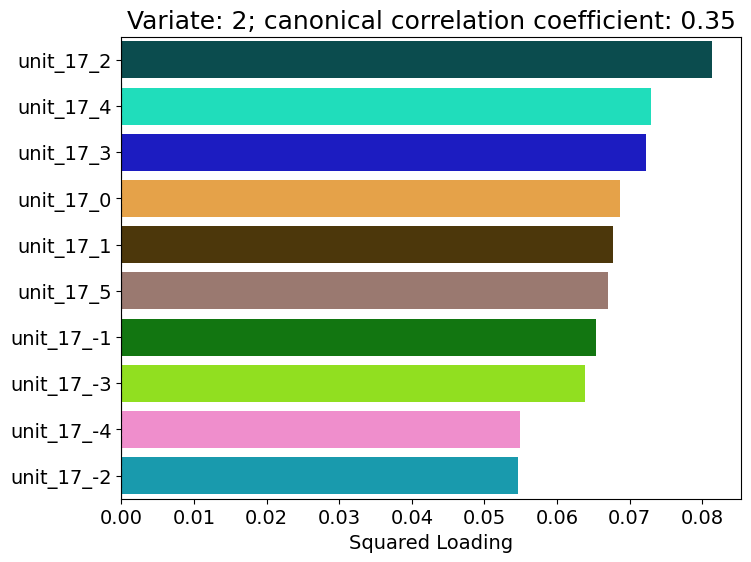

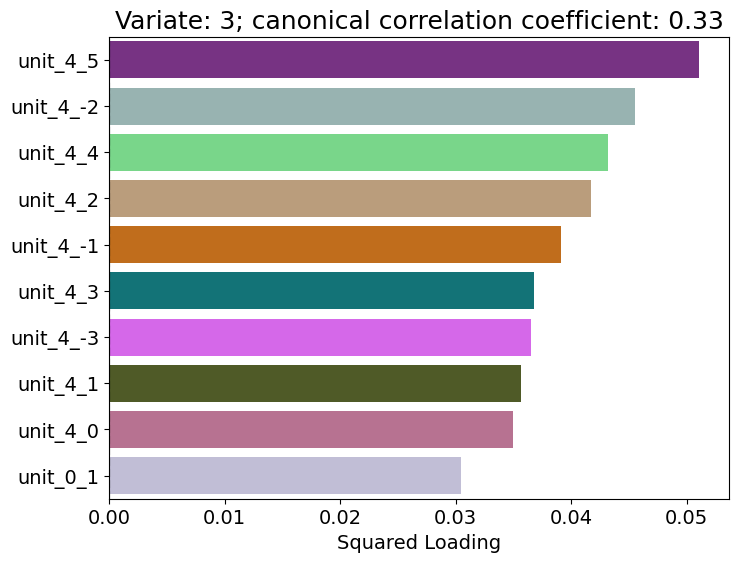

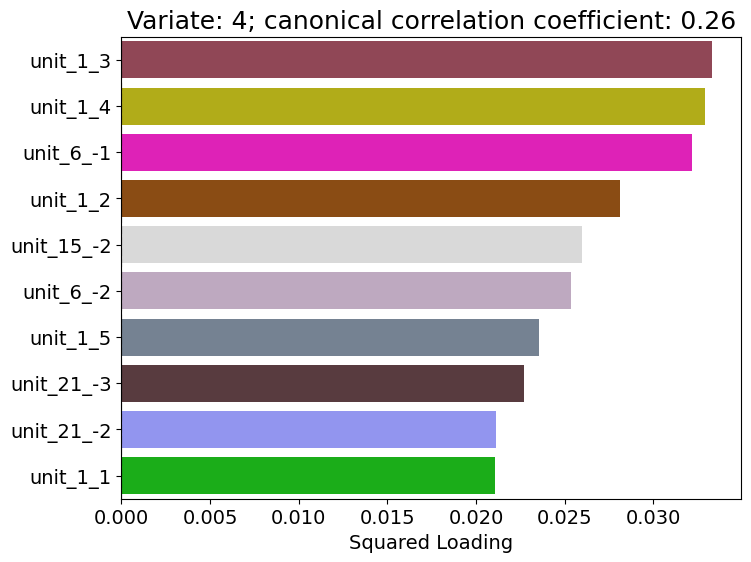

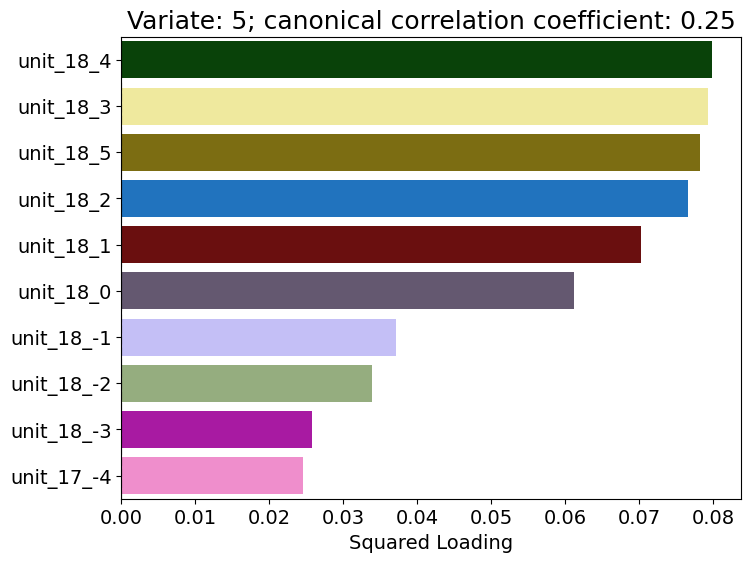

In [23]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

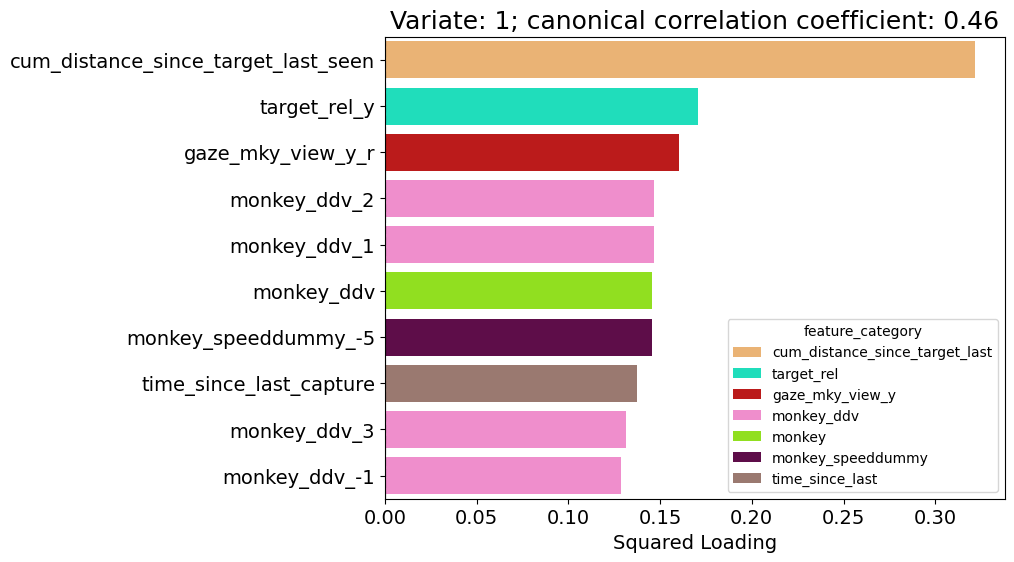

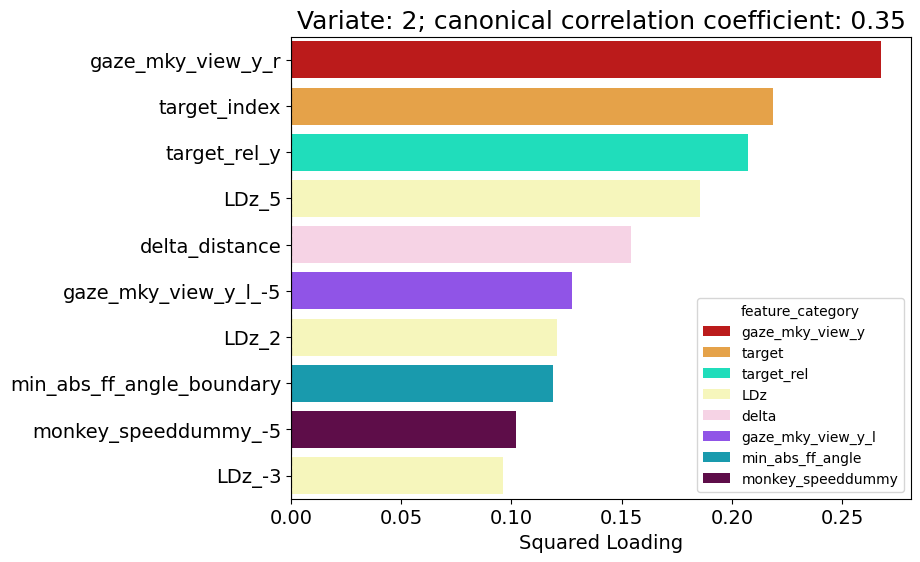

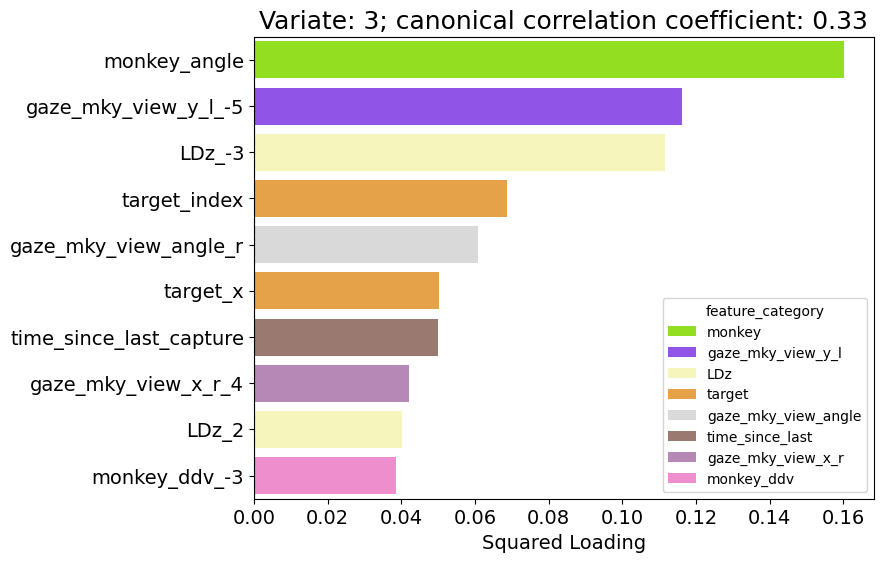

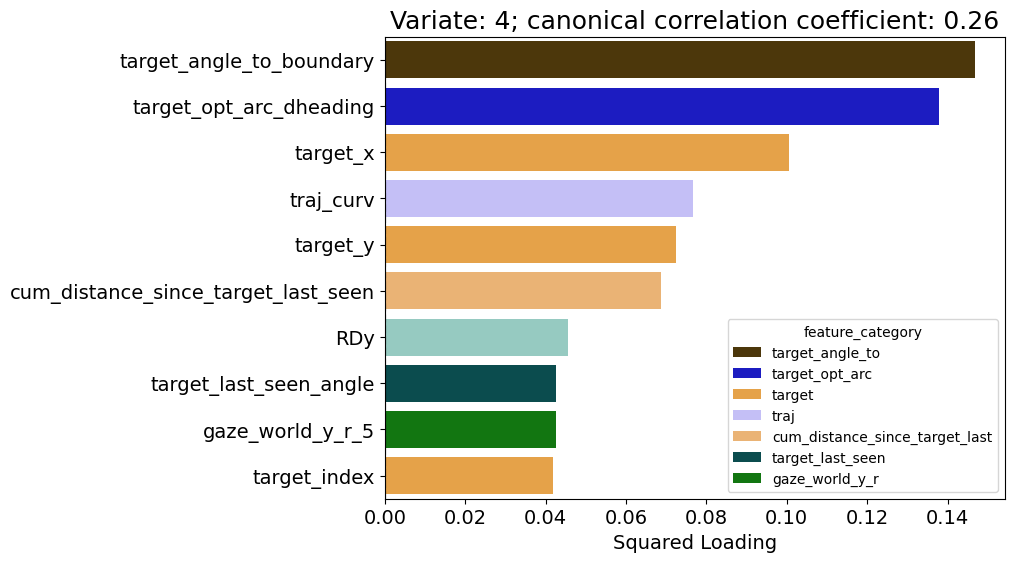

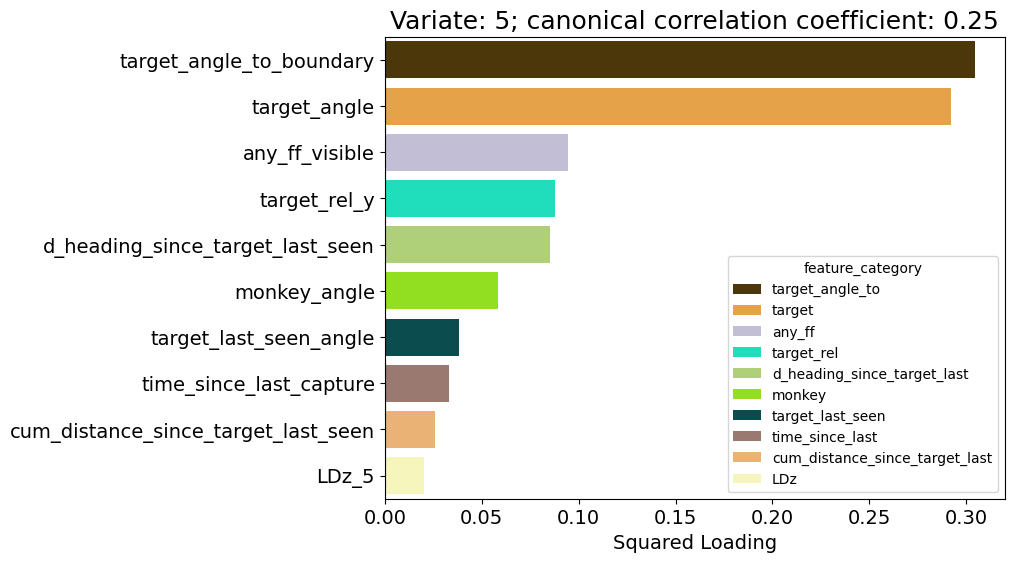

In [24]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## weights (ranked)

### neurons

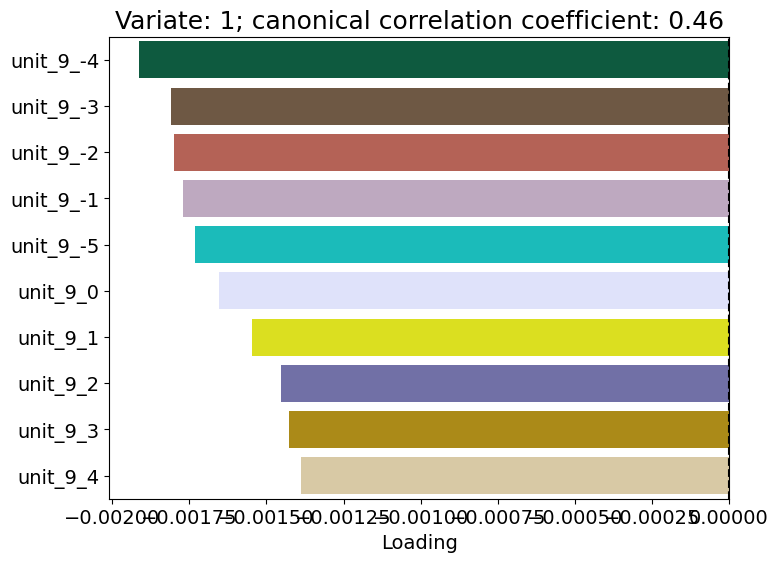

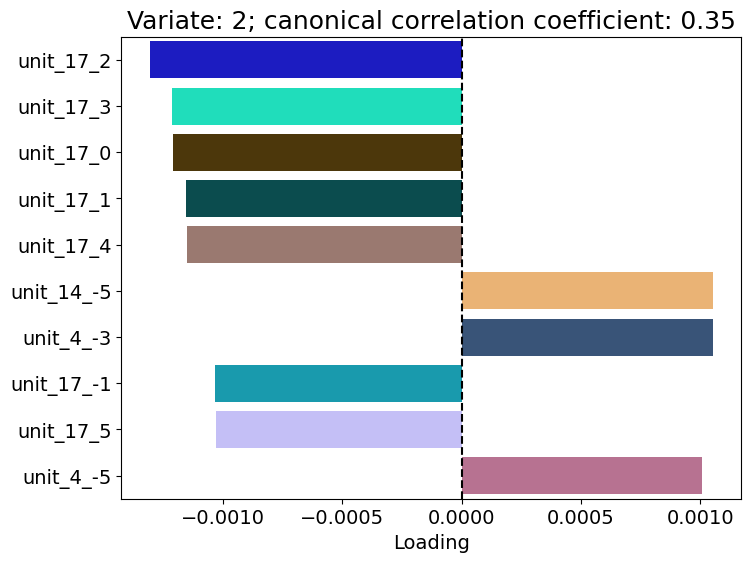

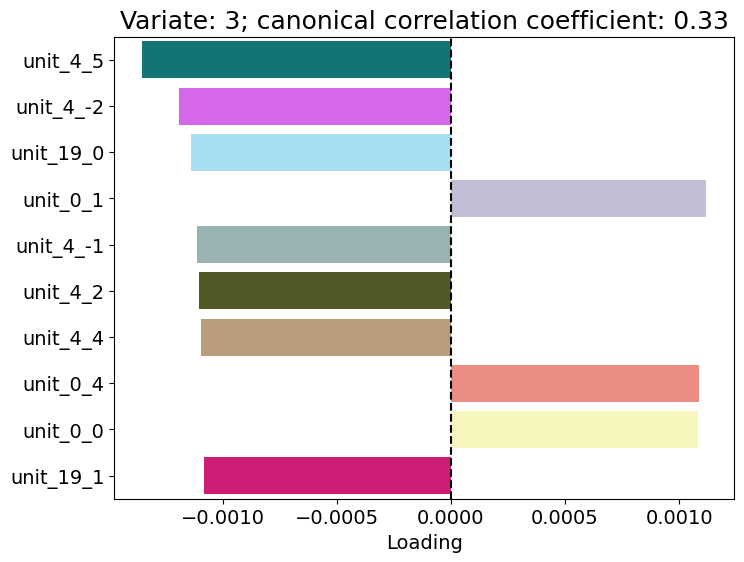

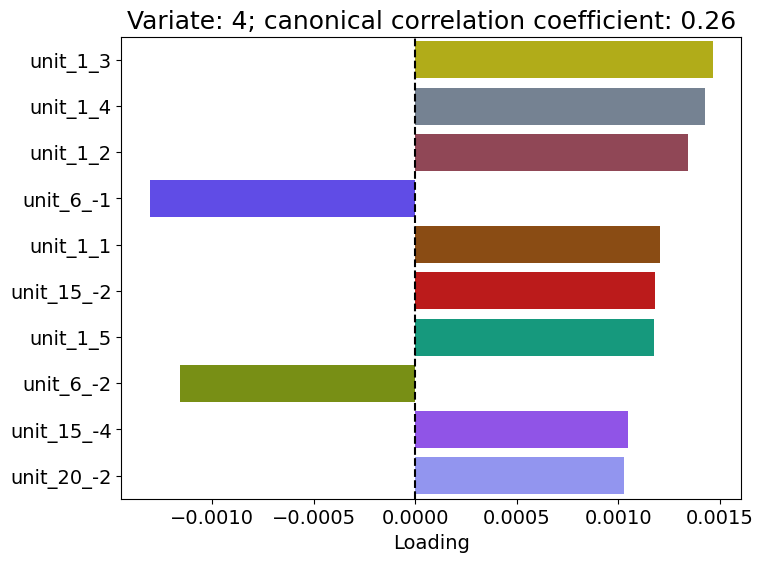

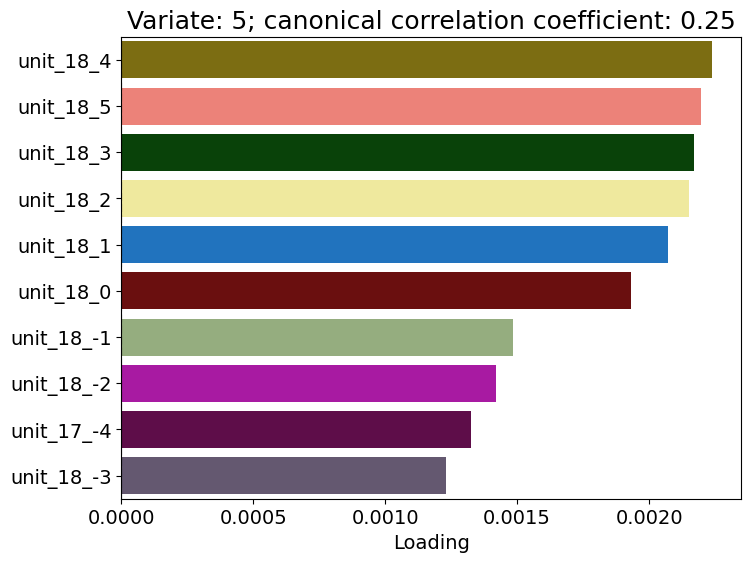

In [49]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

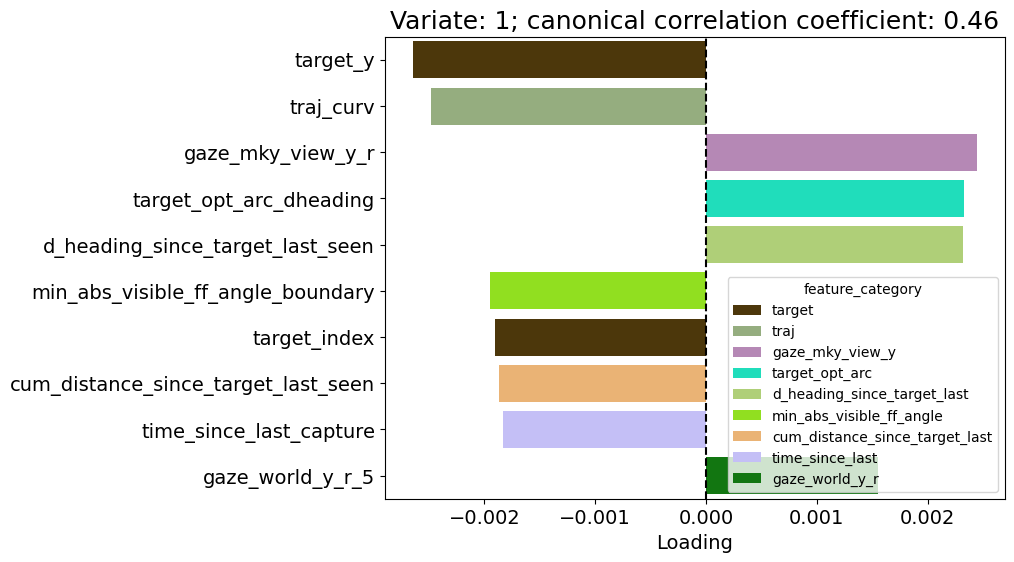

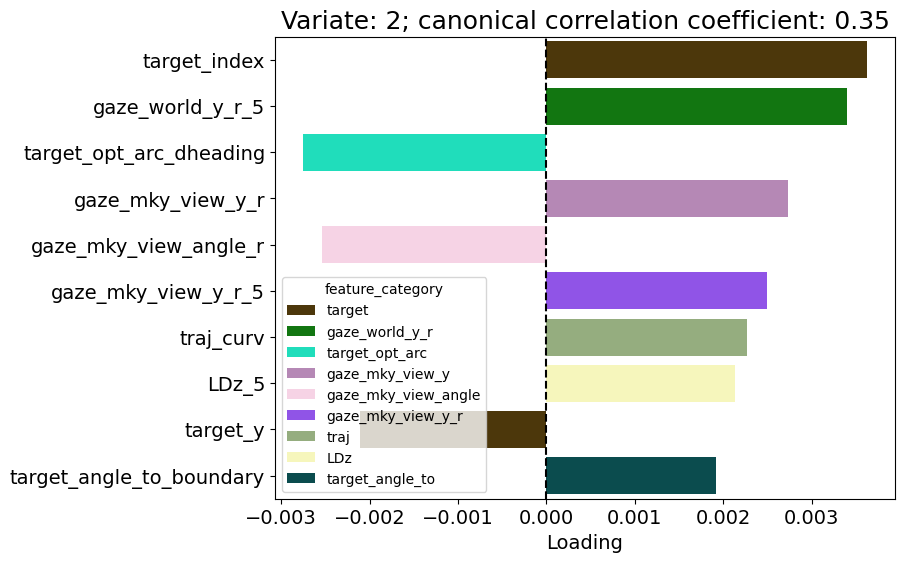

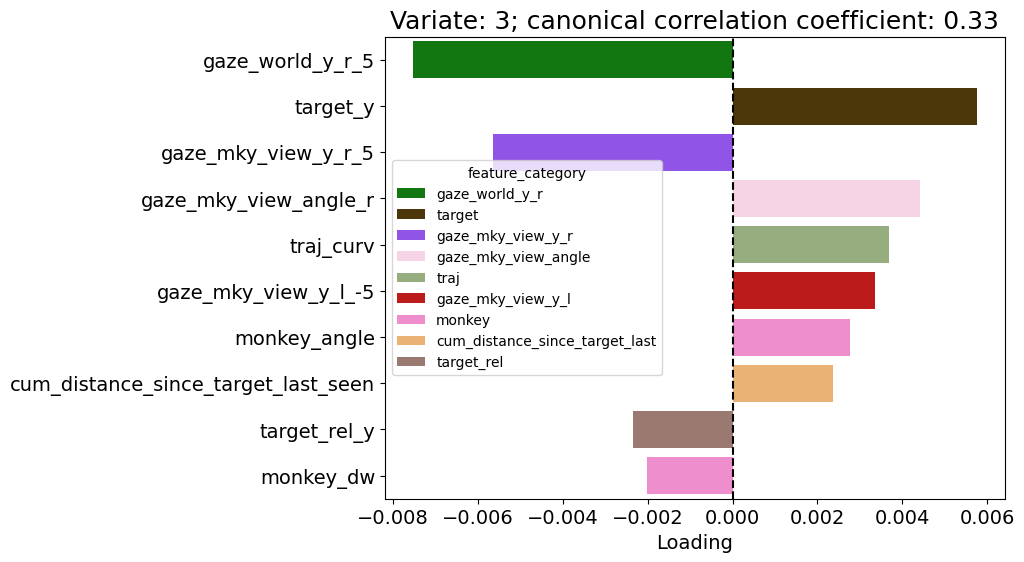

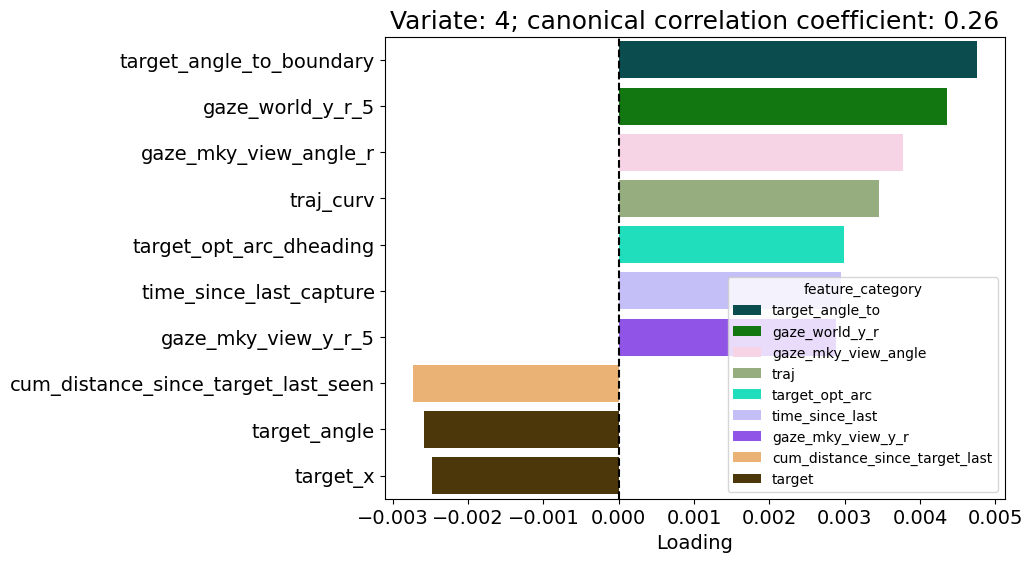

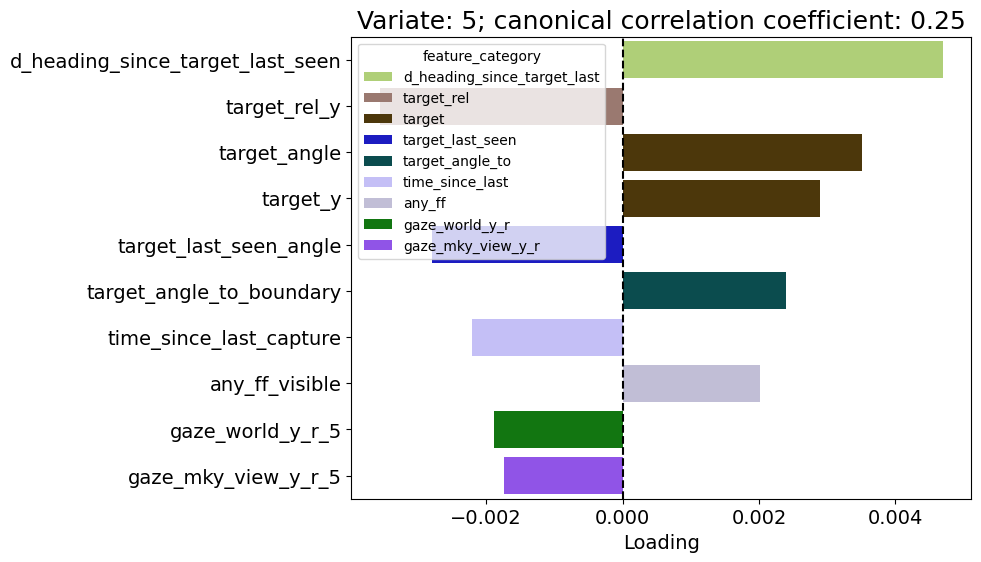

In [50]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

## abs weights ranked

### neurons

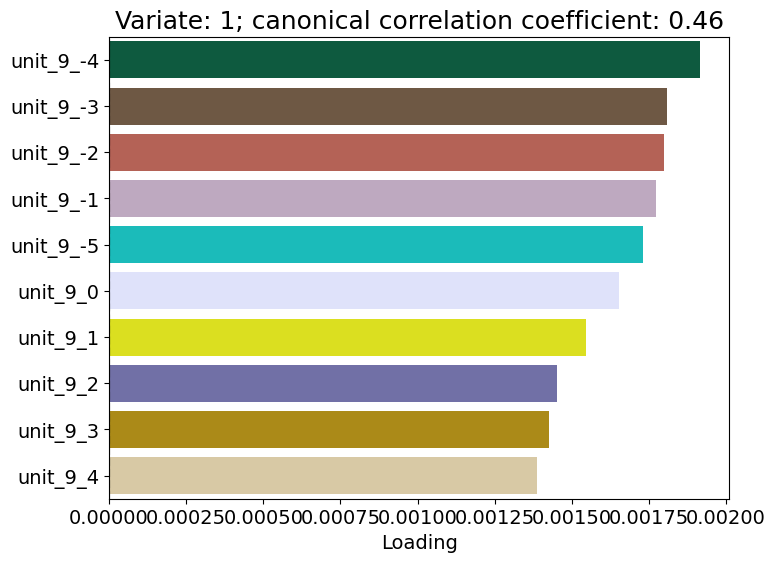

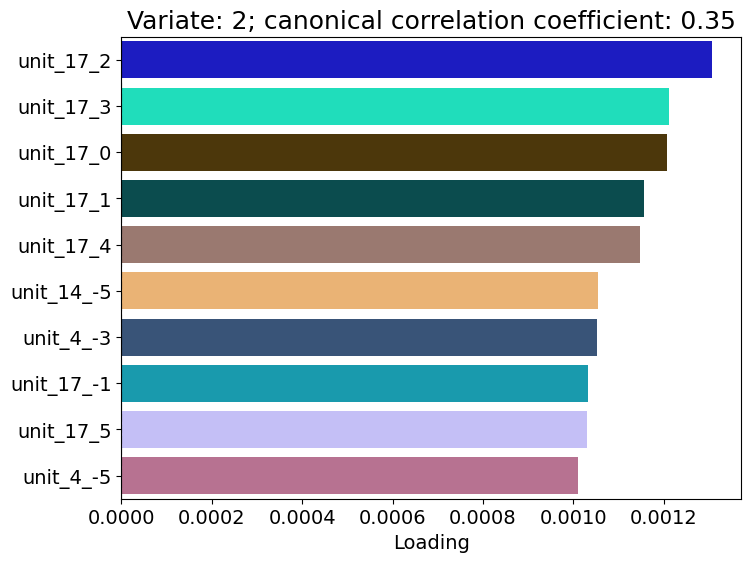

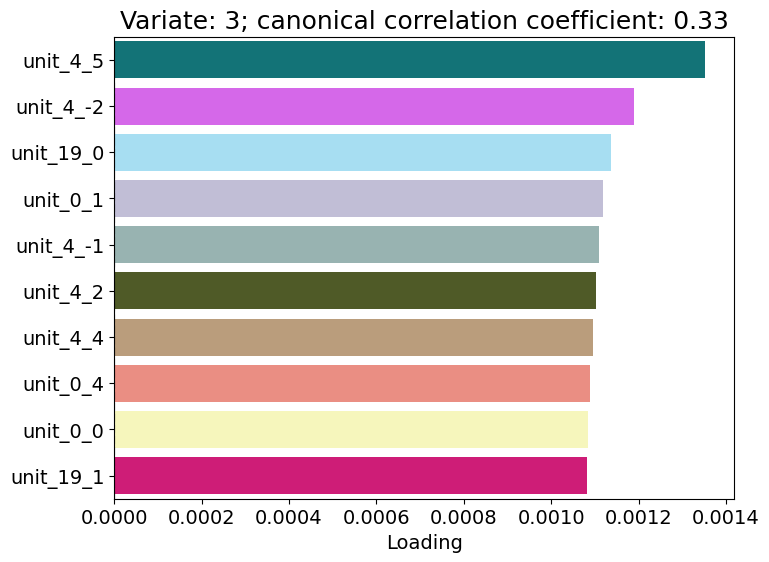

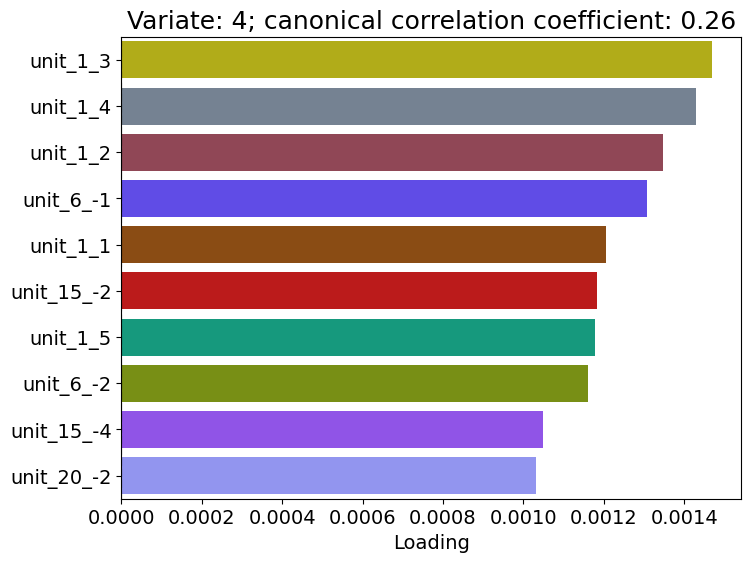

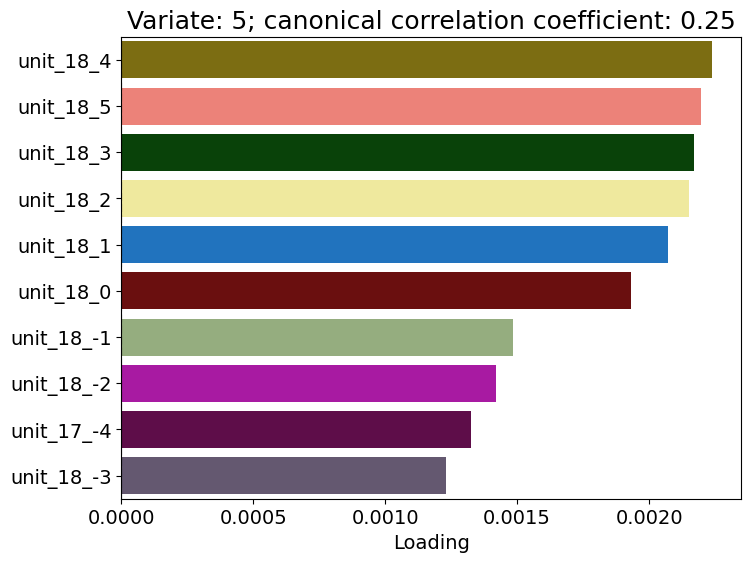

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

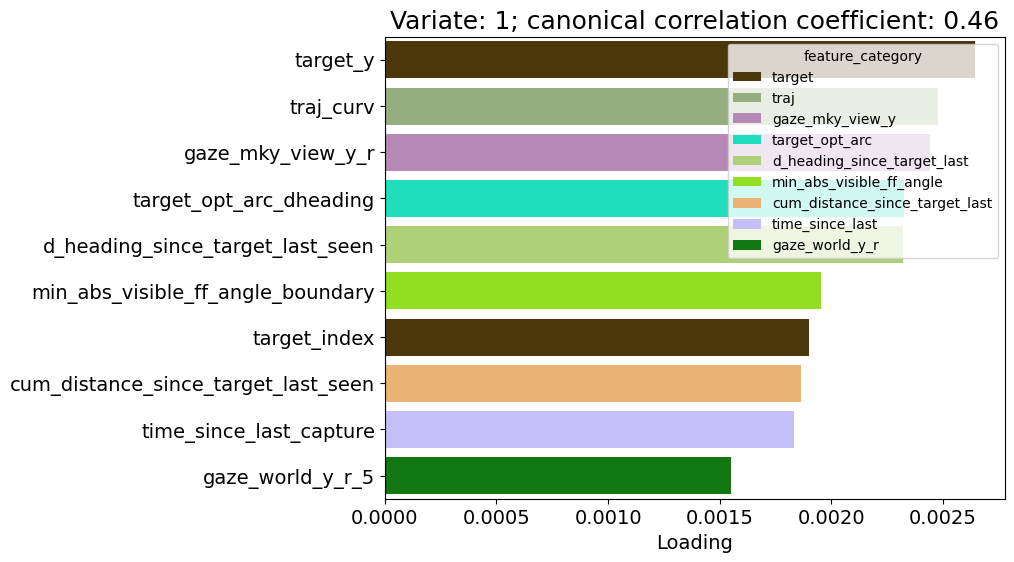

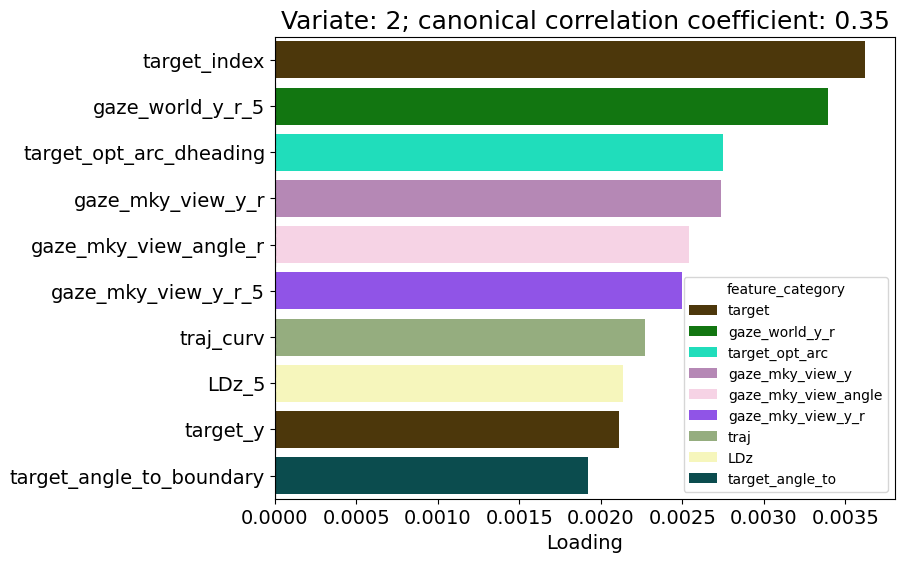

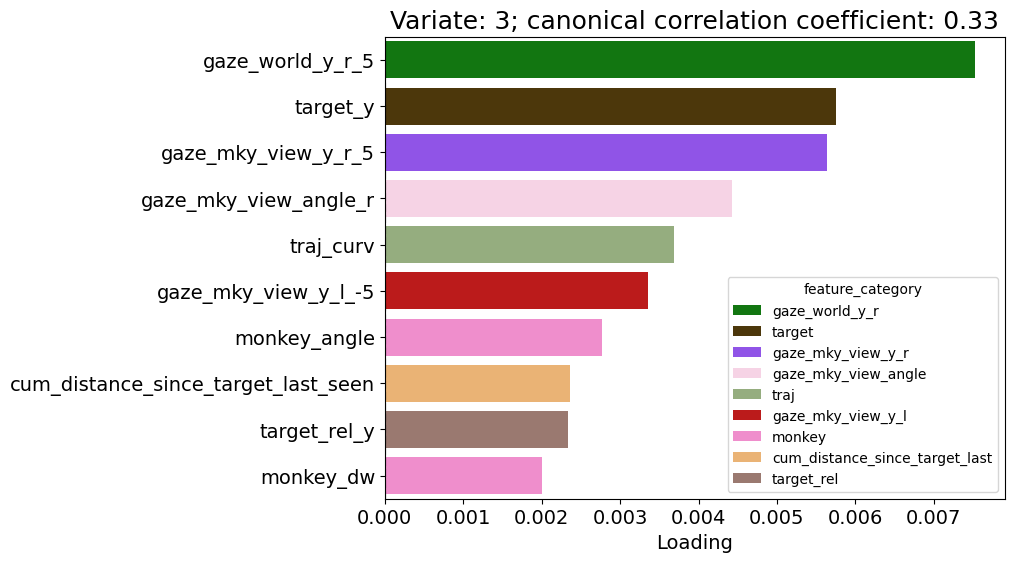

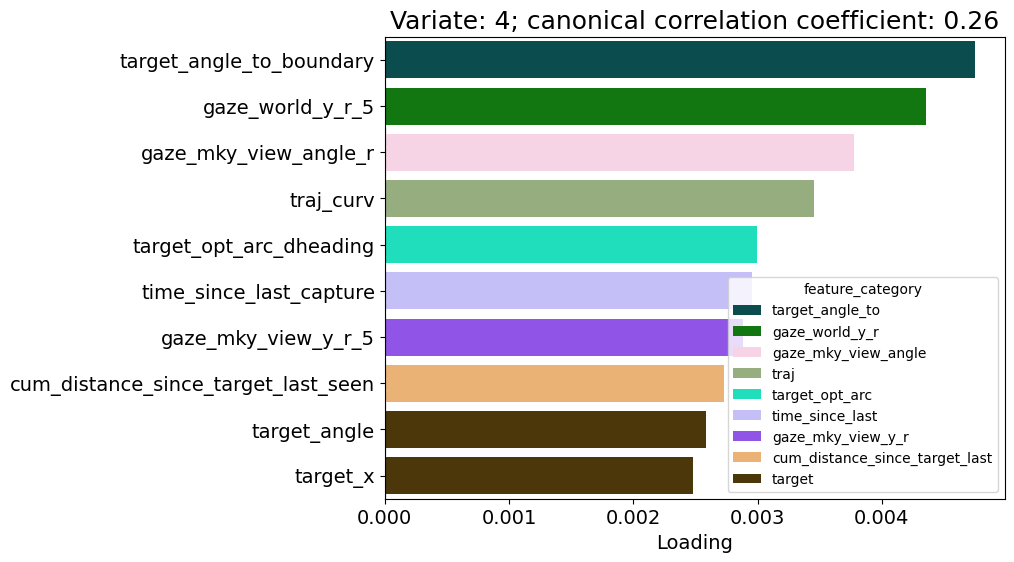

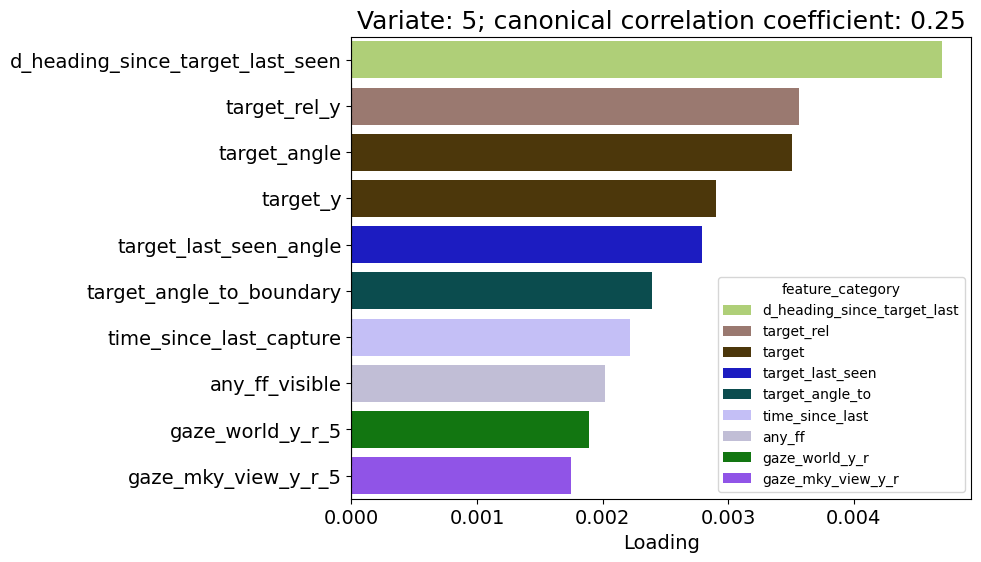

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

In [51]:
stop here!

SyntaxError: invalid syntax (2745754519.py, line 1)

## distribution of each feature

In [52]:
cca_inst.X2_sc.shape

(8507, 87)

In [53]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,whether_new_distinct_stop,delta_distance,RDy,gaze_mky_view_y_r,gaze_mky_view_angle_r,eye_world_speed,min_abs_ff_angle_boundary,min_abs_visible_ff_angle_boundary,catching_ff,any_ff_visible,time_since_last_capture,traj_curv,monkey_ddw_-1,monkey_ddv_-1,whether_new_distinct_stop_-1,eye_world_speed_-1,catching_ff_-1,monkey_ddw_1,monkey_ddv_1,whether_new_distinct_stop_1,eye_world_speed_1,...,monkey_ddv_-5,monkey_speeddummy_-5,whether_new_distinct_stop_-5,gaze_mky_view_y_l_-5,eye_world_speed_-5,catching_ff_-5,monkey_ddw_5,monkey_ddv_5,whether_new_distinct_stop_5,LDz_5,gaze_mky_view_x_r_5,gaze_mky_view_y_r_5,eye_world_speed_5,catching_ff_5,gaze_world_y_r_5,target_angle,target_angle_to_boundary,target_rel_y,target_last_seen_angle,target_opt_arc_dheading,cum_distance_since_target_last_seen,d_heading_since_target_last_seen,target_index,target_x,target_y
count,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,...,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000,8507.00000
mean,0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,...,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000
std,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,...,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006,1.00006
min,-1.88244,-23.88131,-31.88104,-5.89947,-0.11393,-1.41179,-8.66467,-1.62376,-3.55081,-0.27025,-1.43075,-1.51308,-0.06427,-1.04658,-1.35707,-4.79117,-31.98855,-5.92219,-0.15792,-0.34847,-0.14703,-31.76440,-5.93369,-0.10456,-0.23669,...,-6.11457,-1.85847,-0.15753,-1.23261,-0.21986,-0.14535,-31.63462,-6.56470,-0.10224,-2.87815,-2.57984,-0.15958,-0.23569,-0.04203,-57.74501,-4.28876,-6.65210,-1.85443,-7.19539,-4.62697,-1.27207,-3.42537,-1.74497,-2.23409,-2.31675
25%,-0.69847,-0.08720,-0.08065,-0.16721,-0.11393,-1.09368,-0.18914,-0.58137,-0.53463,-0.23152,-0.89907,-0.91383,-0.06427,-1.04658,-0.67871,-0.31213,-0.07397,-0.20103,-0.15792,-0.29746,-0.14703,-0.08803,-0.12303,-0.10456,-0.20368,...,-0.15294,0.53808,-0.15753,-0.59455,-0.18970,-0.14535,-0.07970,-0.05521,-0.10224,-0.40861,-0.18103,-0.07238,-0.20458,-0.04203,-0.48155,-0.28364,0.01201,-0.73811,-0.54547,-0.00157,-0.87387,-0.32178,-0.89183,-0.71505,-0.66464
50%,0.01618,-0.06672,0.02142,0.12968,-0.11393,0.45834,0.14580,-0.21196,-0.12311,-0.17802,-0.15498,0.07259,-0.06427,0.95550,-0.27364,0.17768,0.02062,0.13623,-0.15792,-0.22785,-0.14703,0.02224,0.11110,-0.10456,-0.15723,...,0.14106,0.53808,-0.15753,-0.20272,-0.14781,-0.14535,-0.00059,-0.00491,-0.10224,0.05321,0.00860,-0.04154,-0.15929,-0.04203,0.10234,0.02868,0.01201,-0.28309,0.04768,-0.00139,-0.17855,0.00701,0.07659,0.05613,0.13391
75%,0.92380,0.41387,0.18644,0.26532,-0.11393,0.99692,0.42120,0.36203,0.34878,-0.04096,0.82154,0.77349,-0.06427,0.95550,0.38409,0.56697,0.18081,0.26328,-0.15792,-0.04741,-0.14703,0.19122,0.25768,-0.10456,-0.03934,...,0.23091,0.53808,-0.15753,0.34093,-0.04129,-0.14535,0.18422,0.20640,-0.10224,0.38315,0.19000,0.00927,-0.04824,-0.04203,0.57589,0.305

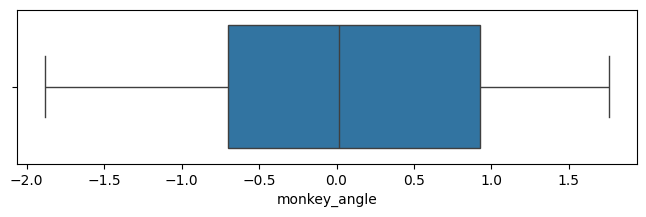

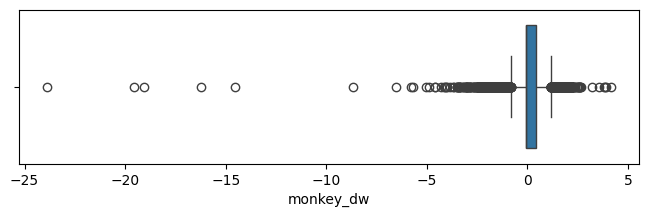

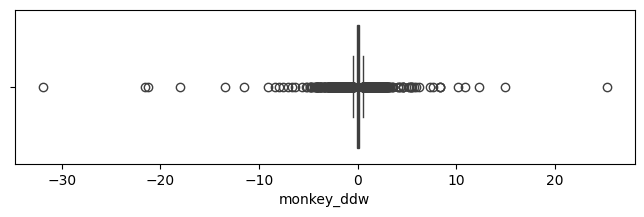

In [55]:
max_plot_to_make = 3

counter = 0
for column in X2_sc_df.columns:
    counter += 1
    if counter > max_plot_to_make:
        break
    
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

## heatmap of weights
Note: raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [56]:
weight_df = cca_inst.X2_weight_df.copy()
weight_df = weight_df.set_index('feature').drop(columns='feature_category')

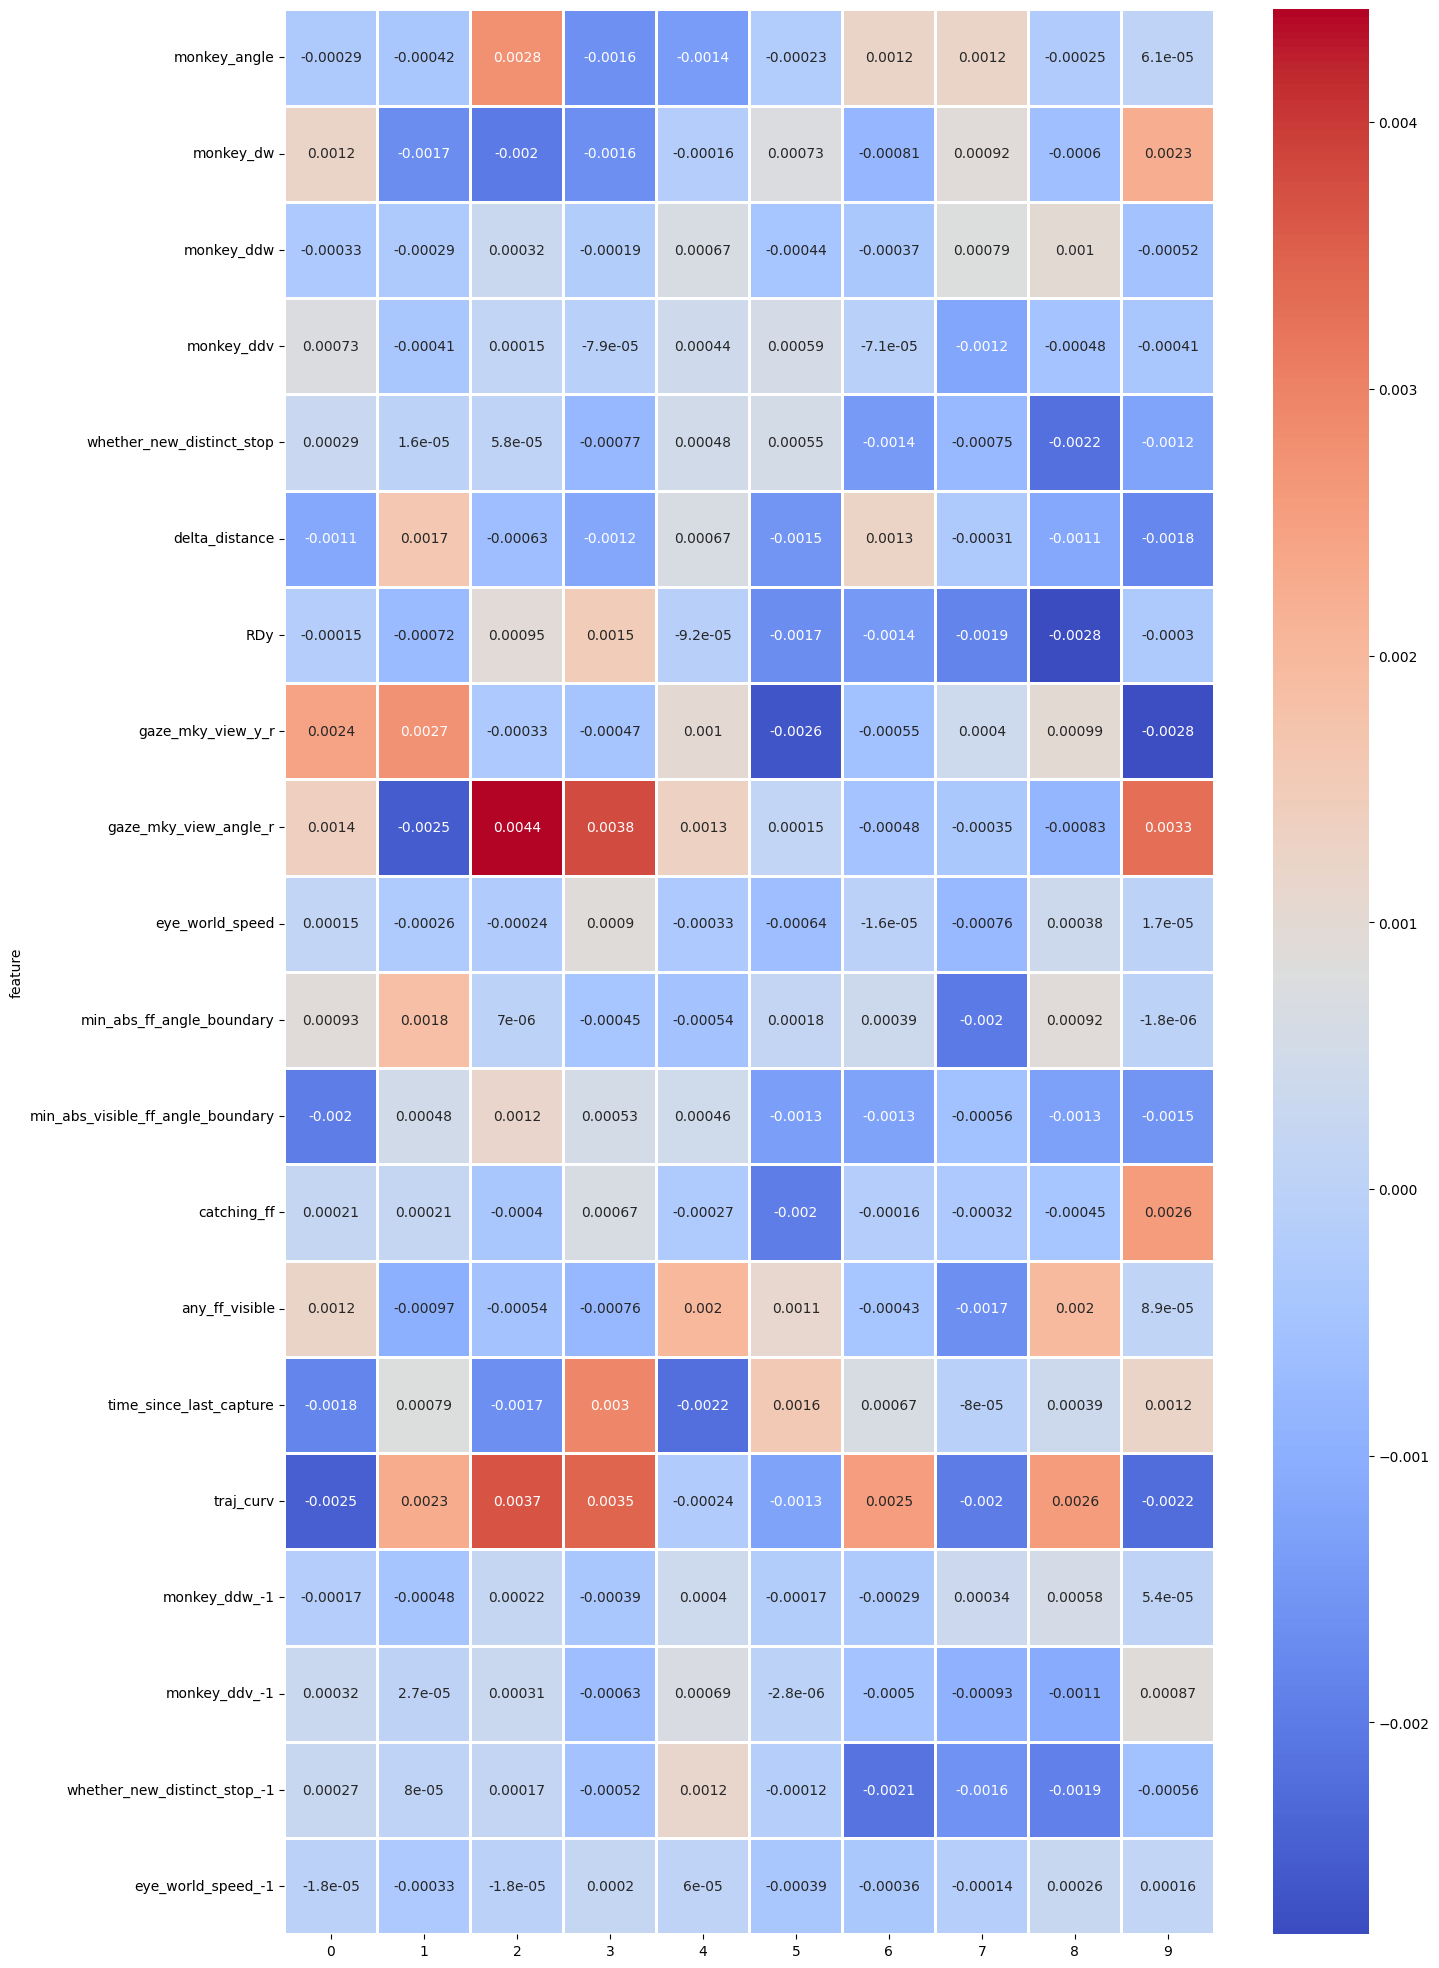

In [57]:
plt.subplots(figsize=(15, 25))
sns.heatmap(weight_df.iloc[:20, :10], cmap='coolwarm', annot=True, linewidths=1)
plt.show()

# Test for p values

In [58]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

                              Cancorr results
   Canonical Correlation Wilks' lambda   Num DF      Den DF   F Value Pr > F
----------------------------------------------------------------------------
0                 0.4622        0.1536 14355.0000 631732.1857  1.0846 0.0000
1                 0.3548        0.1953 14104.0000 625264.9304  0.9610 0.9995
2                 0.3258        0.2234 13855.0000 618786.8606  0.8970 1.0000
3                 0.2565        0.2499 13608.0000 612297.7905  0.8445 1.0000
4                 0.2475        0.2675 13363.0000 605797.5298  0.8175 1.0000
5                 0.2252        0.2850 13120.0000 599285.8841  0.7925 1.0000
6                 0.2239        0.3002 12879.0000 592762.6545  0.7738 1.0000
7                 0.2111        0.3160 12640.0000 586227.6378  0.7546 1.0000
8                 0.2072        0.3308 12403.0000 579680.6259  0.7384 1.0000
9                 0.2035        0.3456 12168.0000 573121.4062  0.7227 1.0000
10                0.1982      

## compute explained variance

In [59]:
cca2.compute_ev([test1, test2])

NameError: name 'cca2' is not defined

In [ ]:
stop pls

# Train test split

## no lag: train vs test

In [89]:
n_splits = 5
reg = 0.1
n_components = 10

cca_inst = cca_lags

X1_df = cca_inst.X1_sc_df
X2_df = cca_inst.X2_sc_df

# Canonical correlations
canon_corr_stats, cross_view_corr_stats = cca_cv_utils.crossvalidated_cca_analysis(X1_df, X2_df, n_components=n_components, reg=reg, n_splits=n_splits)


Training CCA, kernel = None, regularization = 0.1000, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


In [92]:
cca_no_lag.traincorrs = cca2.validate([train1, train2])
cca_no_lag.testcorrs = cca2.validate([test1, test2])


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


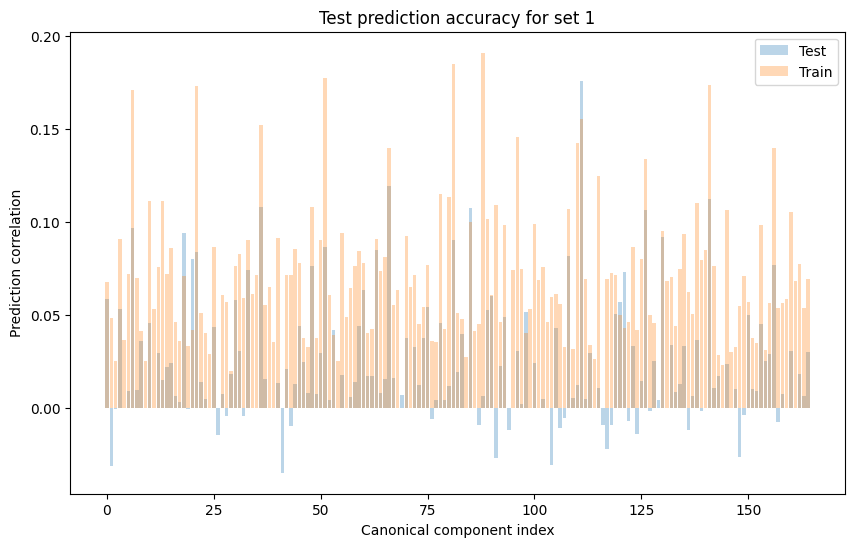

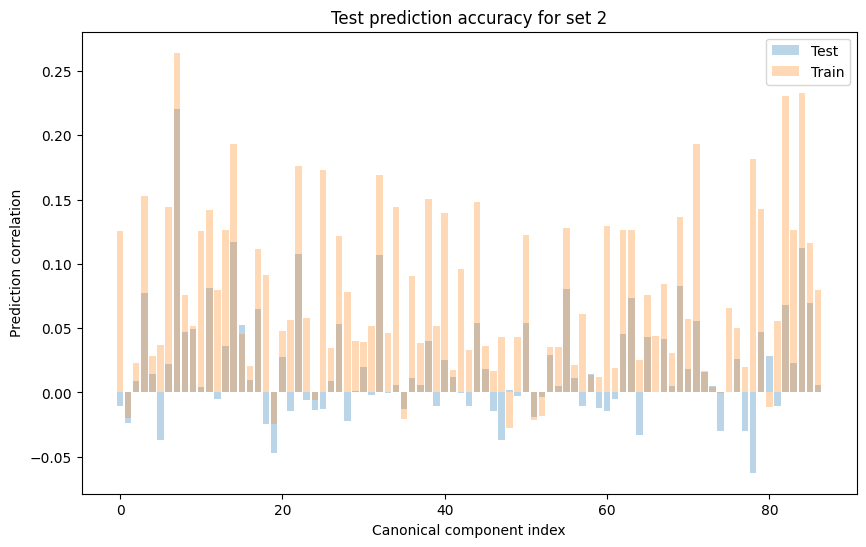

<Figure size 1000x600 with 0 Axes>

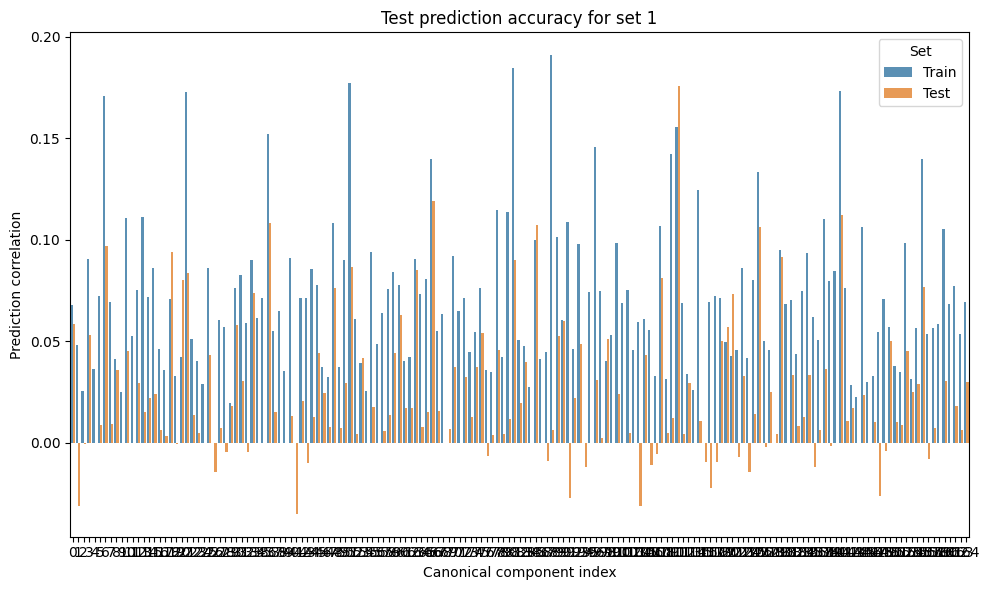

<Figure size 1000x600 with 0 Axes>

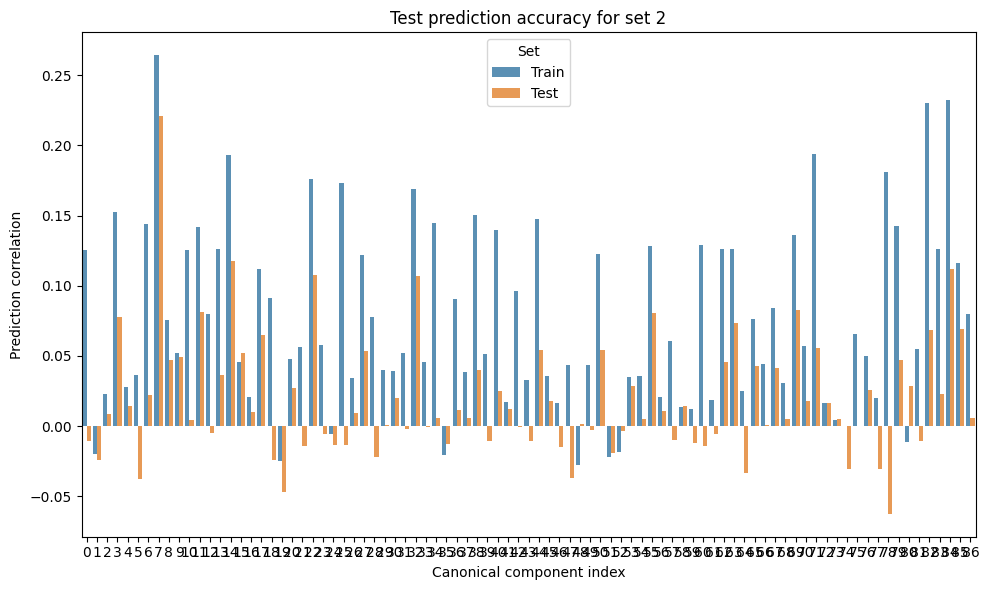

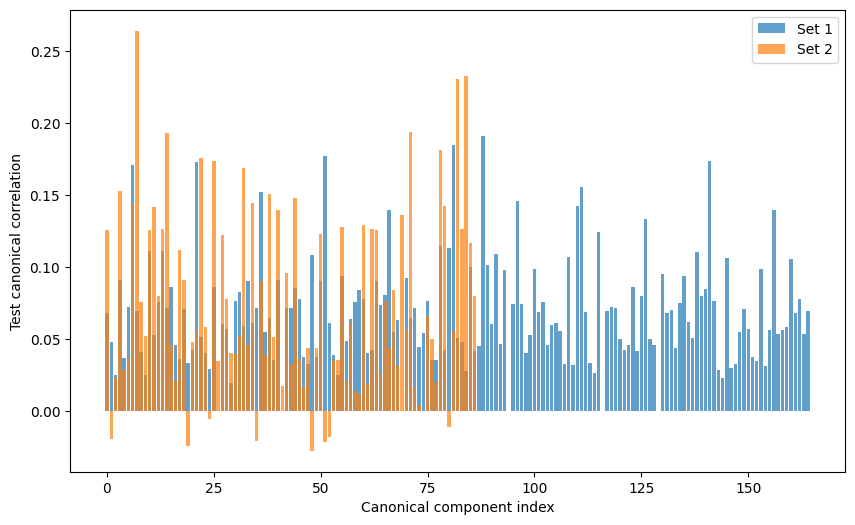

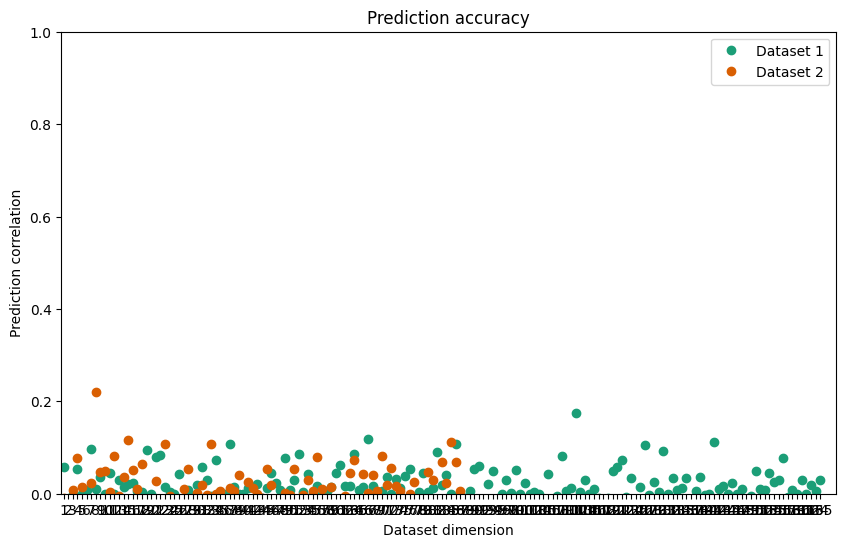

In [80]:
train1, test1, train2, test2 = train_test_split(cca_inst.X1_sc, cca_inst.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0.1, numCC = nComponents)
cca2.train([train1, train2])

cca_inst.traincorrs = cca2.validate([train1, train2])
cca_inst.testcorrs = cca2.validate([test1, test2])

cca_plotting.plot_cca_prediction_accuracy_train_test_bars(cca_inst.traincorrs, cca_inst.testcorrs)
cca_plotting.plot_cca_prediction_accuracy_train_test_stacked_bars(cca_inst.traincorrs, cca_inst.testcorrs)
cca_plotting.plot_cca_prediction_accuracy_test_w_bars(cca_inst.traincorrs)
cca_plotting.plot_cca_prediction_accuracy_w_scatter(cca_inst.testcorrs)

## with lags: train vs test

In [107]:
# # check for problems in the data
# cca_lags.x_var_reduced = prep_decode_target.remove_zero_var_cols(
#             cca_lags.X2_sc_df)
# _ = prep_decode_target.remove_zero_var_cols(
#             test1)

Training CCA, kernel = None, regularization = 0.0001, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


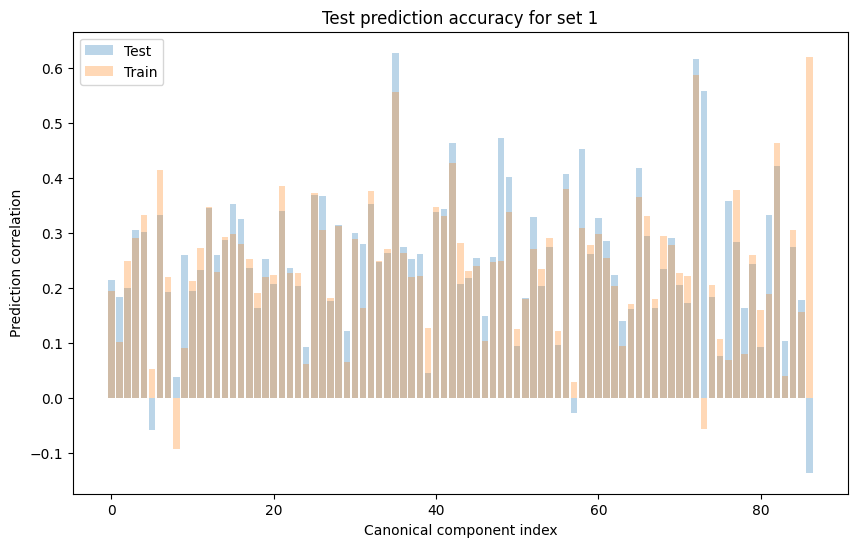

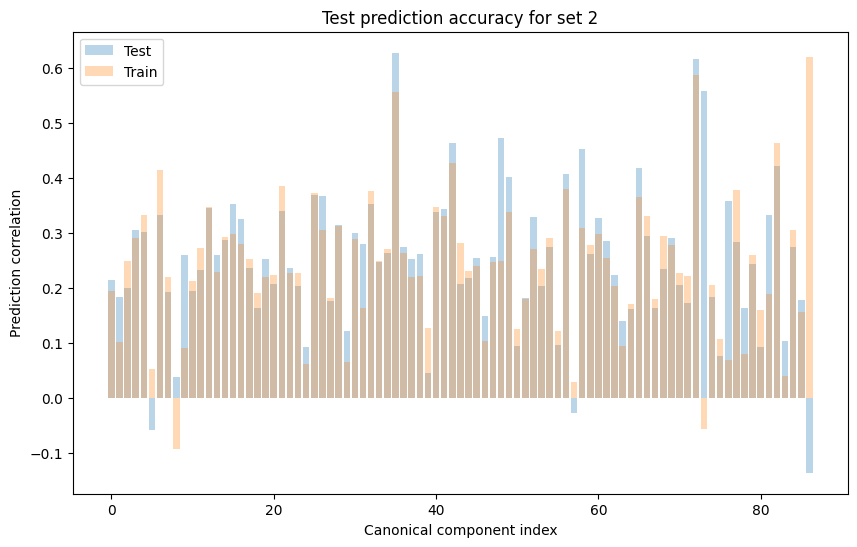

<Figure size 1000x600 with 0 Axes>

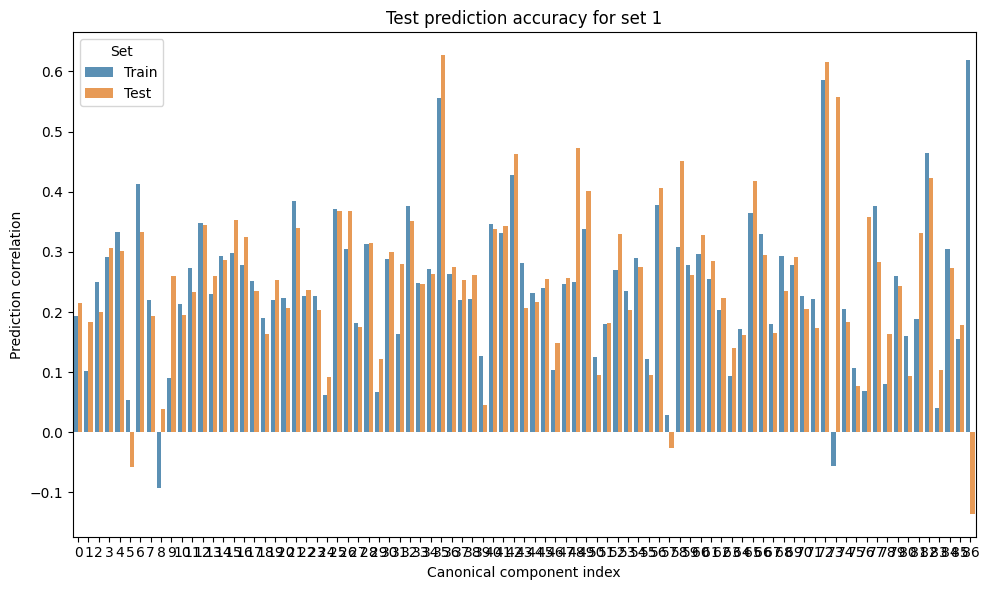

<Figure size 1000x600 with 0 Axes>

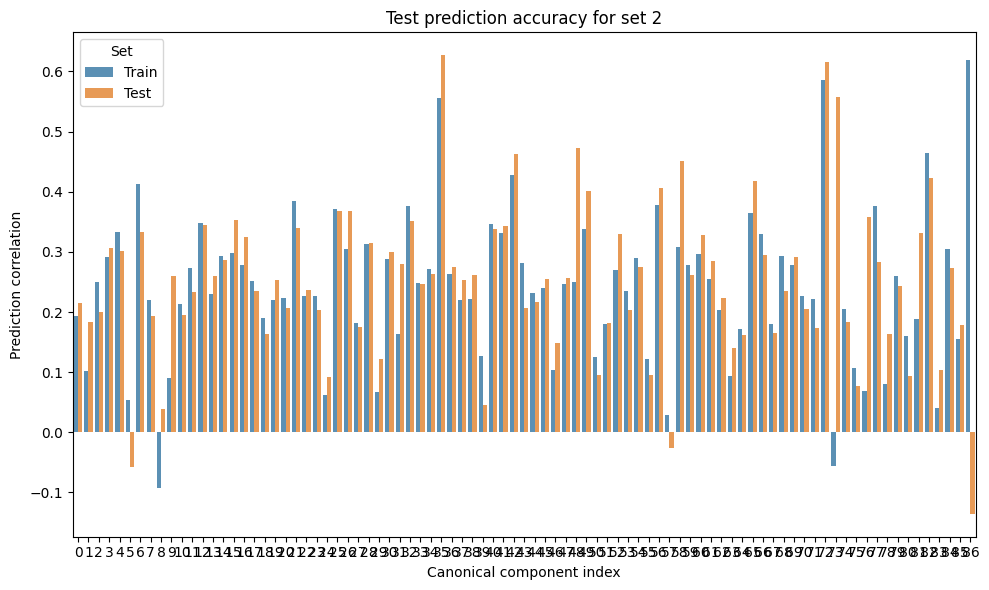

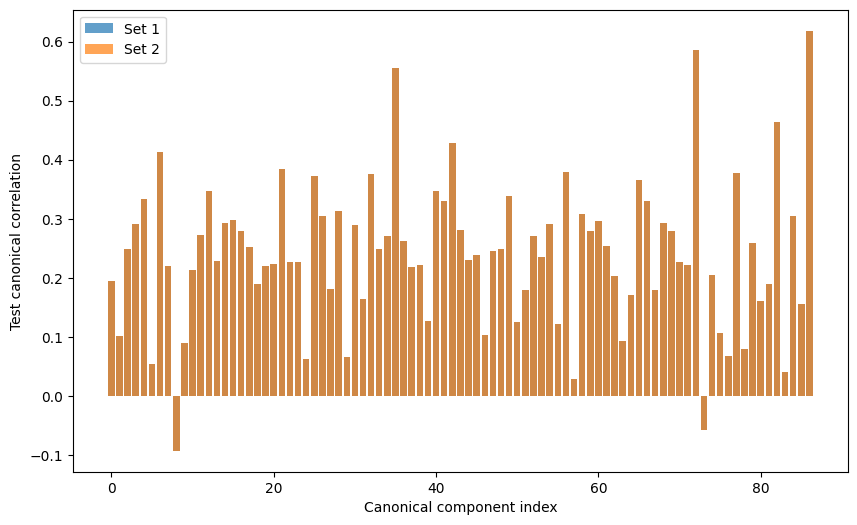

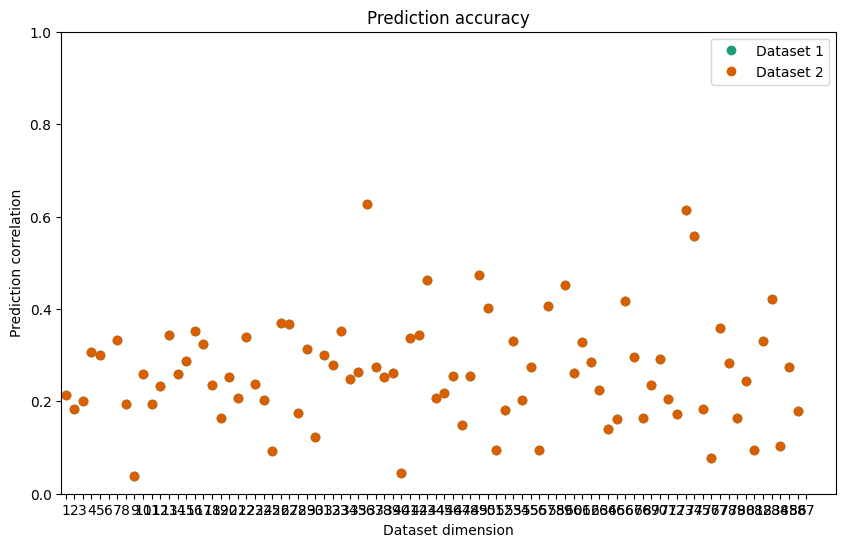

In [124]:

train1, test1, train2, test2 = train_test_split(cca_no_lag.X1_sc, cca_no_lag.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg=1e-4, numCC = nComponents)
cca2.train([train1, train2])

cca_no_lag.traincorrs = cca2.validate([train1, train2])
cca_no_lag.testcorrs = cca2.validate([test1, test2])



train1, test1, train2, test2 = train_test_split(cca_lags.X1_sc, cca_lags.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])

cca_lags.traincorrs = cca2.validate([train1, train2])
cca_lags.testcorrs = cca2.validate([test1, test2])


cca_plotting.plot_cca_prediction_accuracy_train_test_bars(cca_lags.traincorrs, cca_lags.testcorrs)
cca_plotting.plot_cca_prediction_accuracy_train_test_stacked_bars(cca_lags.traincorrs, cca_lags.testcorrs)
cca_plotting.plot_cca_prediction_accuracy_test_w_bars(cca_lags.traincorrs)
cca_plotting.plot_cca_prediction_accuracy_w_scatter(cca_lags.testcorrs)

## compare lags vs no lag

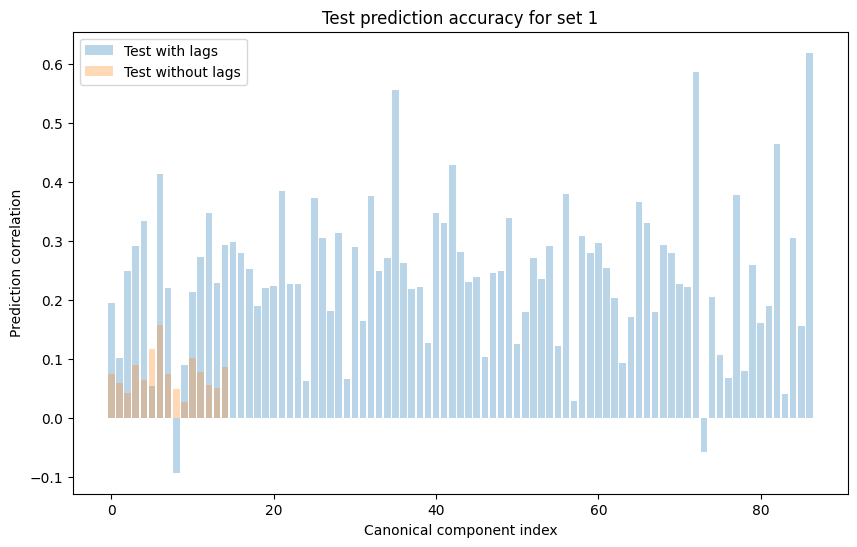

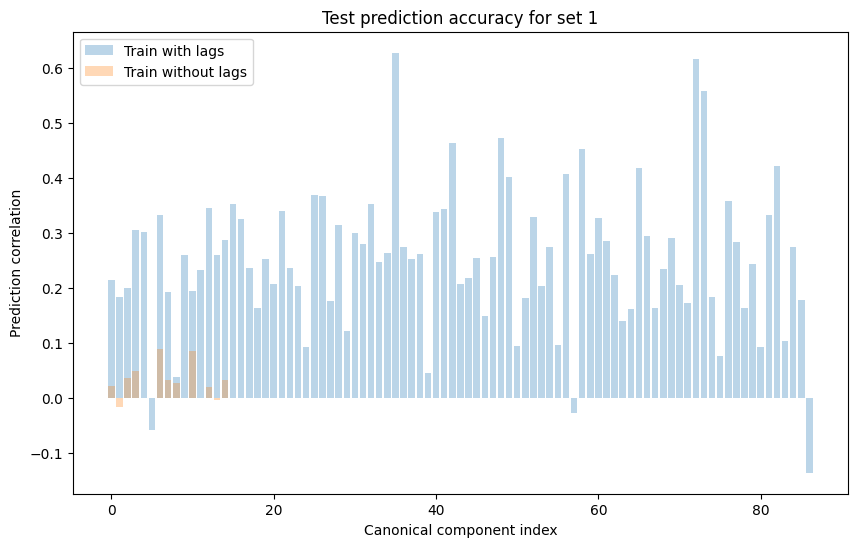

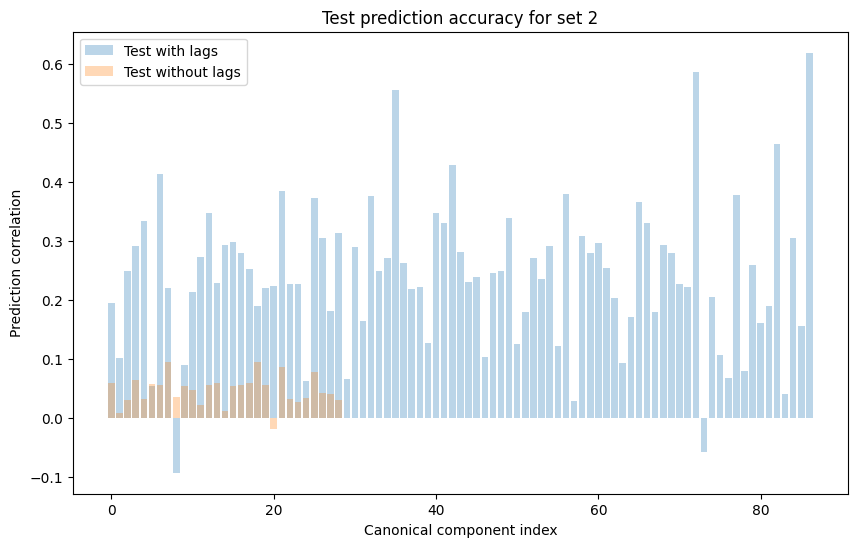

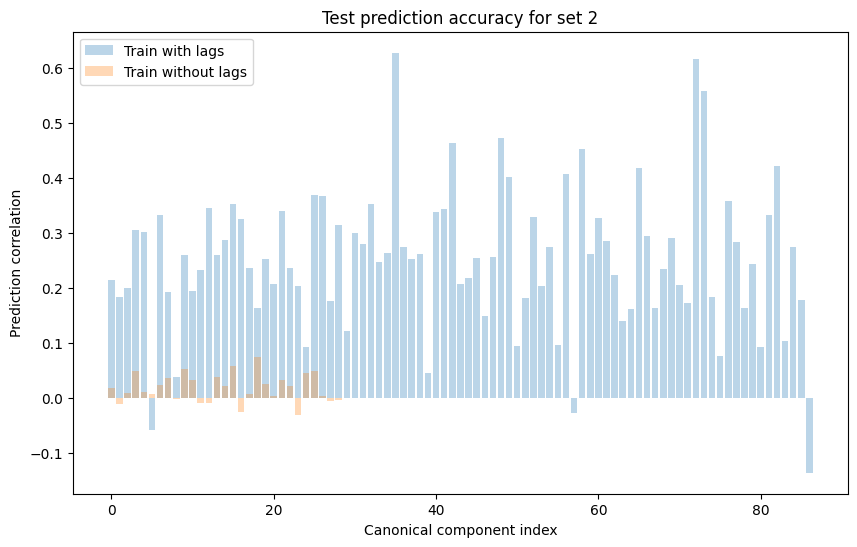

In [125]:
cca_lag_vs_no_lag_plotting.plot_cca_prediction_accuracy_train_test_bars_for_lags_and_no_lags(cca_lags.traincorrs, cca_lags.testcorrs, cca_no_lag.traincorrs, cca_no_lag.testcorrs)

# exp

In [126]:
n_splits = 5
reg = 0.1
n_components = 10

cca_inst = cca_lags

X1_df = cca_inst.X1_sc_df
X2_df = cca_inst.X2_sc_df

# Canonical correlations
canon_corr_stats, cross_view_corr_stats = cca_cv_utils.crossvalidated_cca_analysis(X1_df, X2_df, n_components=n_components, reg=reg, n_splits=n_splits)


Training CCA, kernel = None, regularization = 0.1000, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


In [ ]:
cca_lag_vs_no_lag_plotting.plot_cca_lag_vs_nolag_and_train_vs_test(combined_X2_df, 'DatasetName', mode='train_offset')


## compare lags vs no lag & train vs test

In [64]:
combined_X1_df, combined_X2_df = cca_lag_vs_no_lag_plotting.combine_data_to_compare_train_and_test(cca_no_lag, cca_lags)

In [129]:
# can make this into a df based on combined_X2_df

cross_view_corr_stats.keys()

dict_keys(['mean_X1_train_corr', 'mean_X1_test_corr', 'mean_X2_train_corr', 'mean_X2_test_corr', 'std_X1_train_corr', 'std_X1_test_corr', 'std_X2_train_corr', 'std_X2_test_corr', 'X1_labels', 'X2_labels'])

In [127]:
combined_X2_df

,corr,train_or_test,whether_lag,var,dataset
40,0.02528,test,no_lag,LDz_-3,X2
40,0.02528,test,lag,LDz_-3,X2
40,0.13940,train,no_lag,LDz_-3,X2
40,0.13940,train,lag,LDz_-3,X2
34,0.14439,train,lag,LDz_2,X2
...,...,...,...,...,...
56,0.01091,test,lag,whether_new_distinct_stop_4,X2
70,0.01798,test,no_lag,whether_new_distinct_stop_5,X2
70,0.05711,train,lag,whether_new_distinct_stop_5,X2
70,0.05711,train,no_lag,whether_new_distinct_stop_5,X2


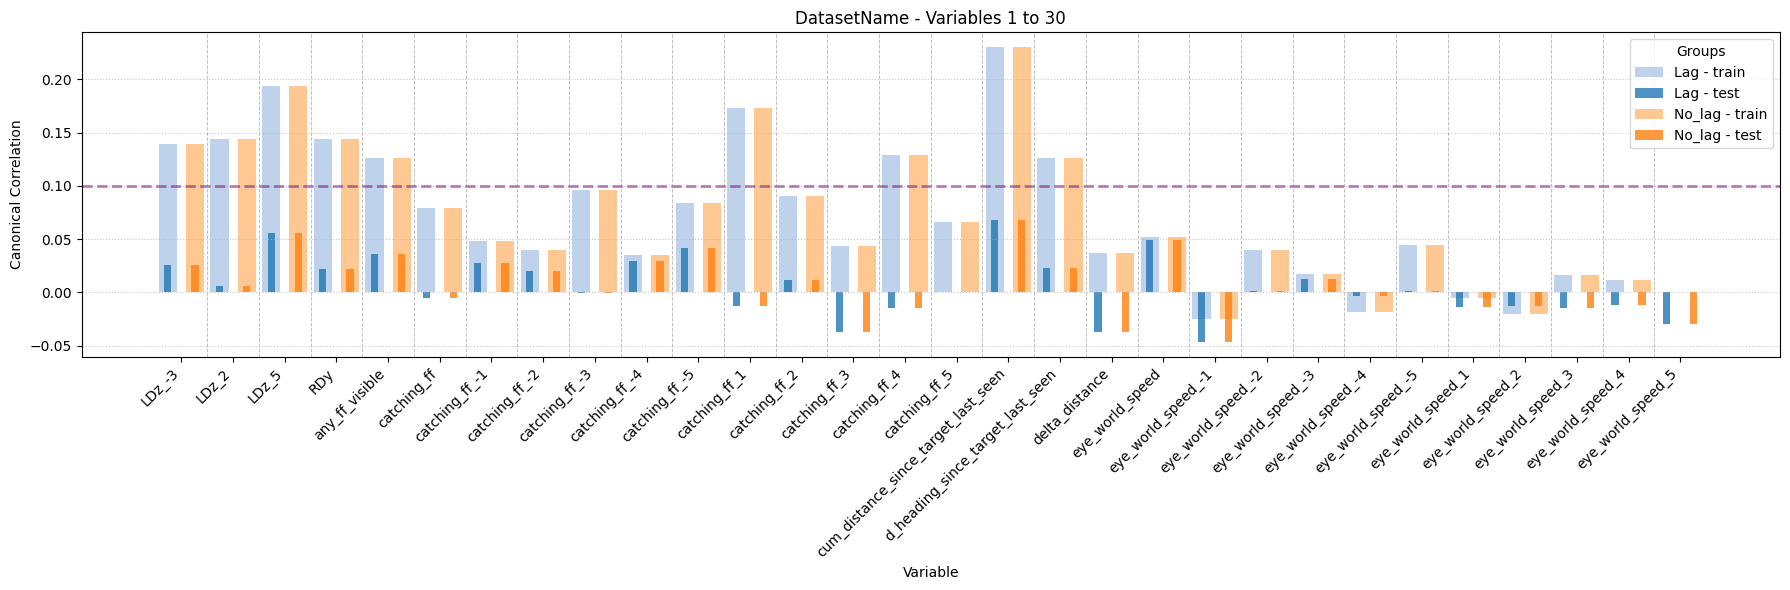

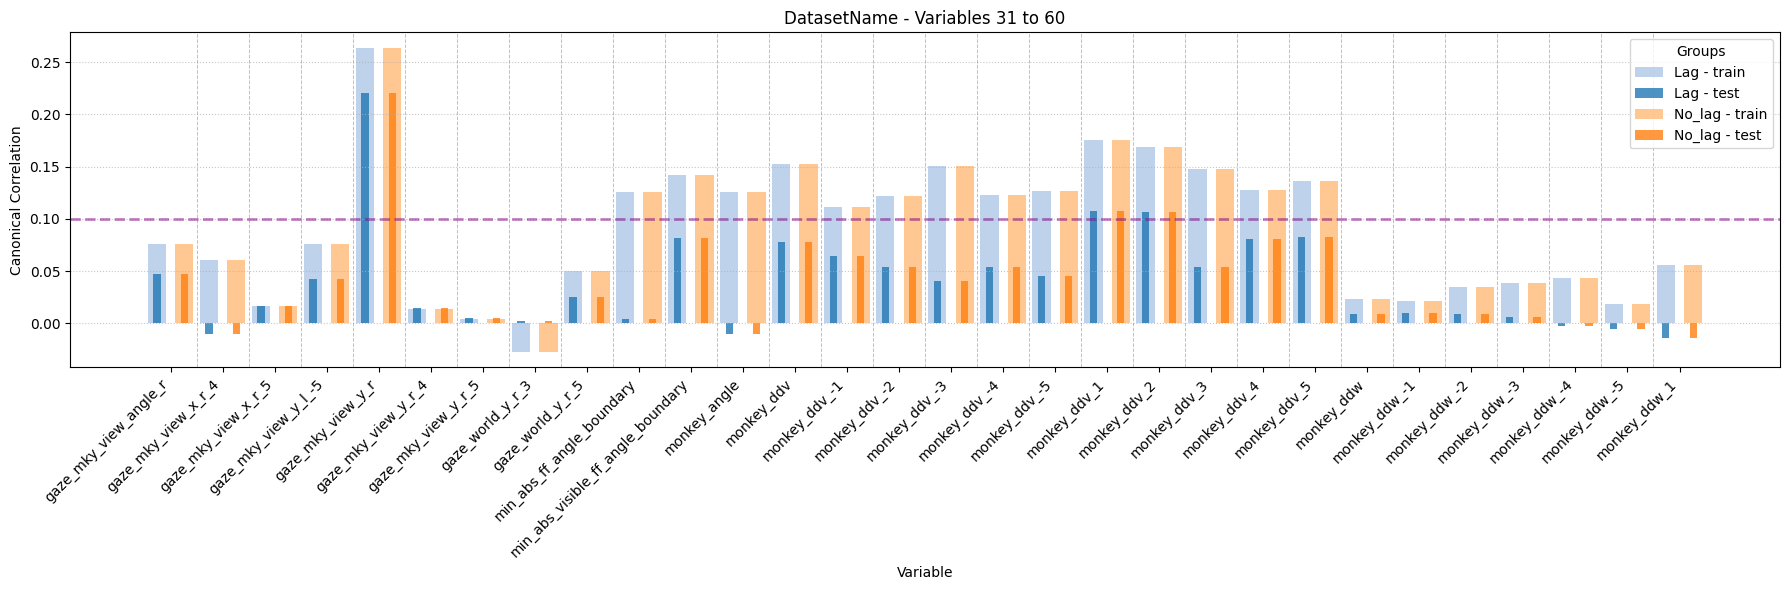

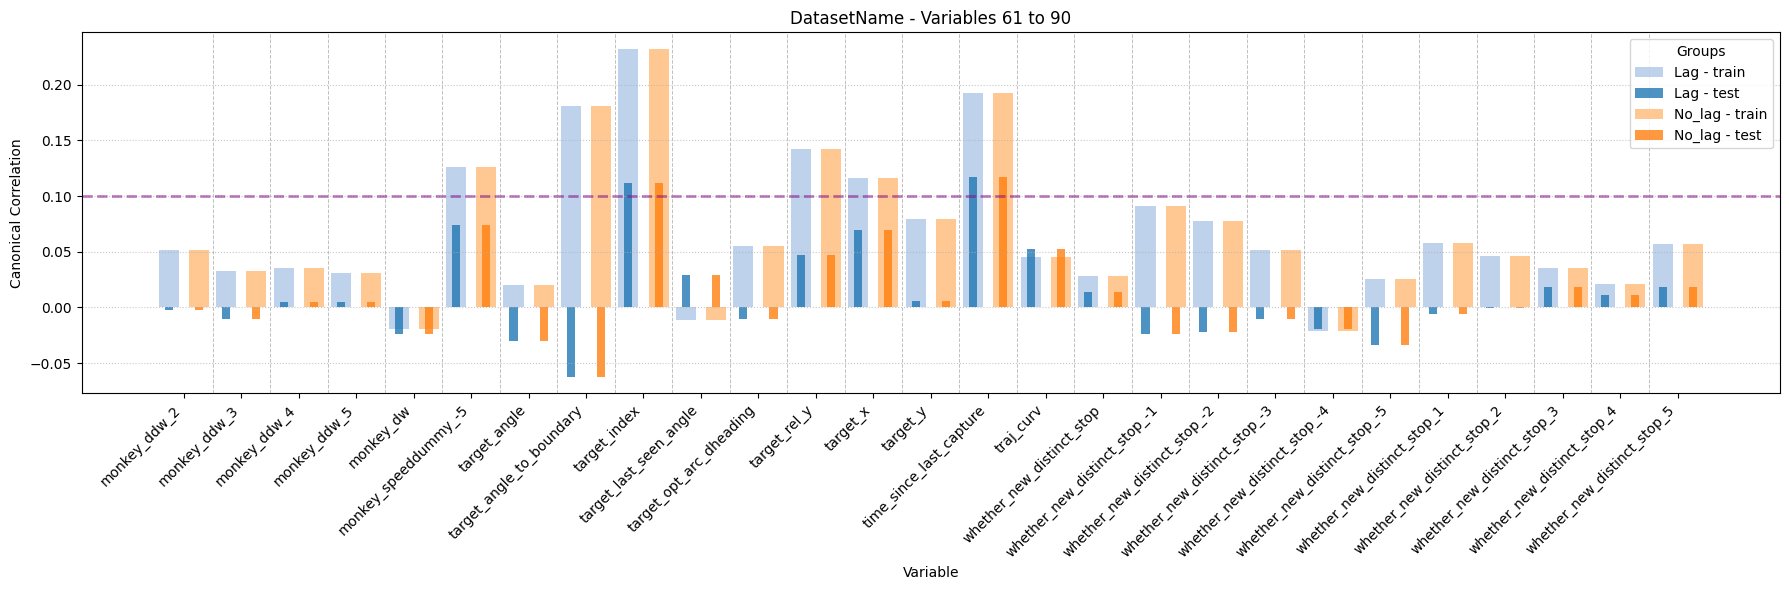

In [65]:
cca_lag_vs_no_lag_plotting.plot_cca_lag_vs_nolag_and_train_vs_test(combined_X2_df, 'DatasetName', mode='lag_offset')


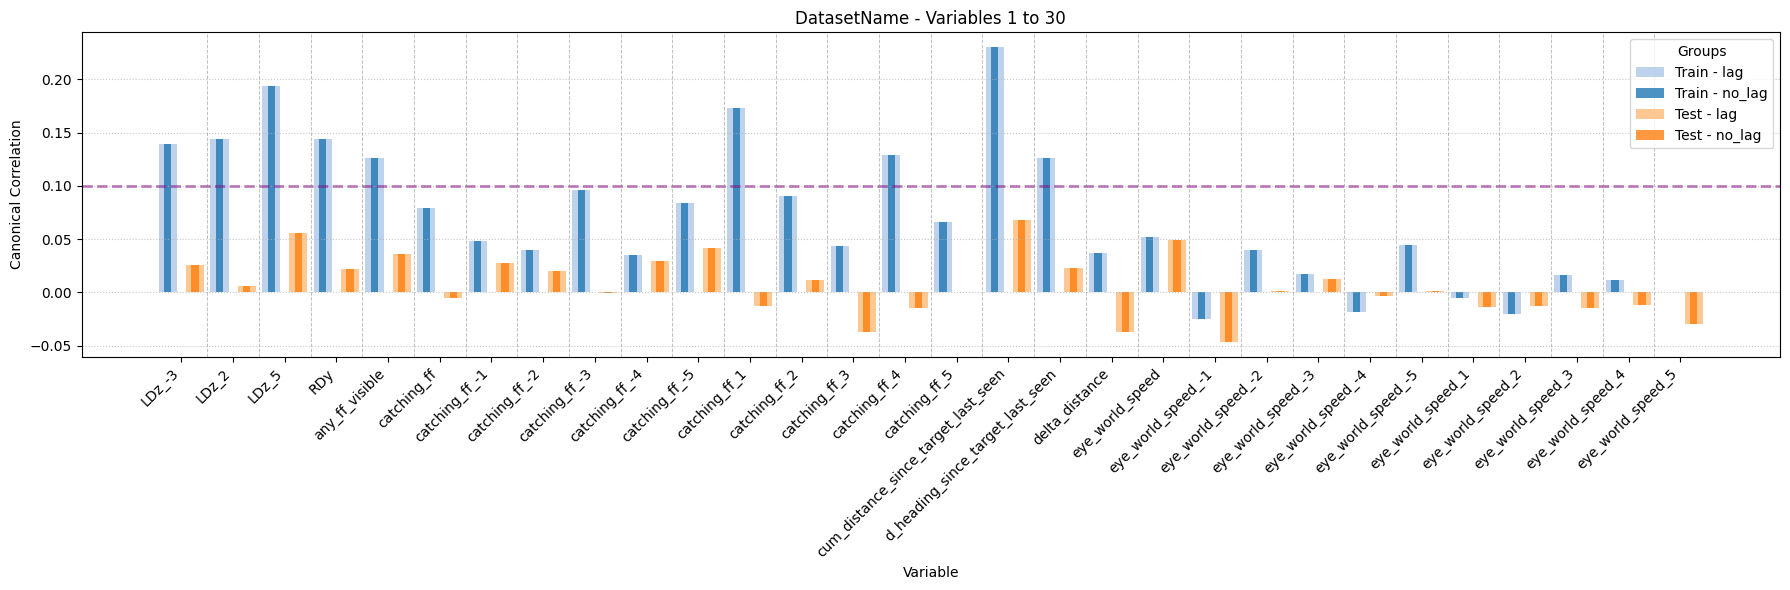

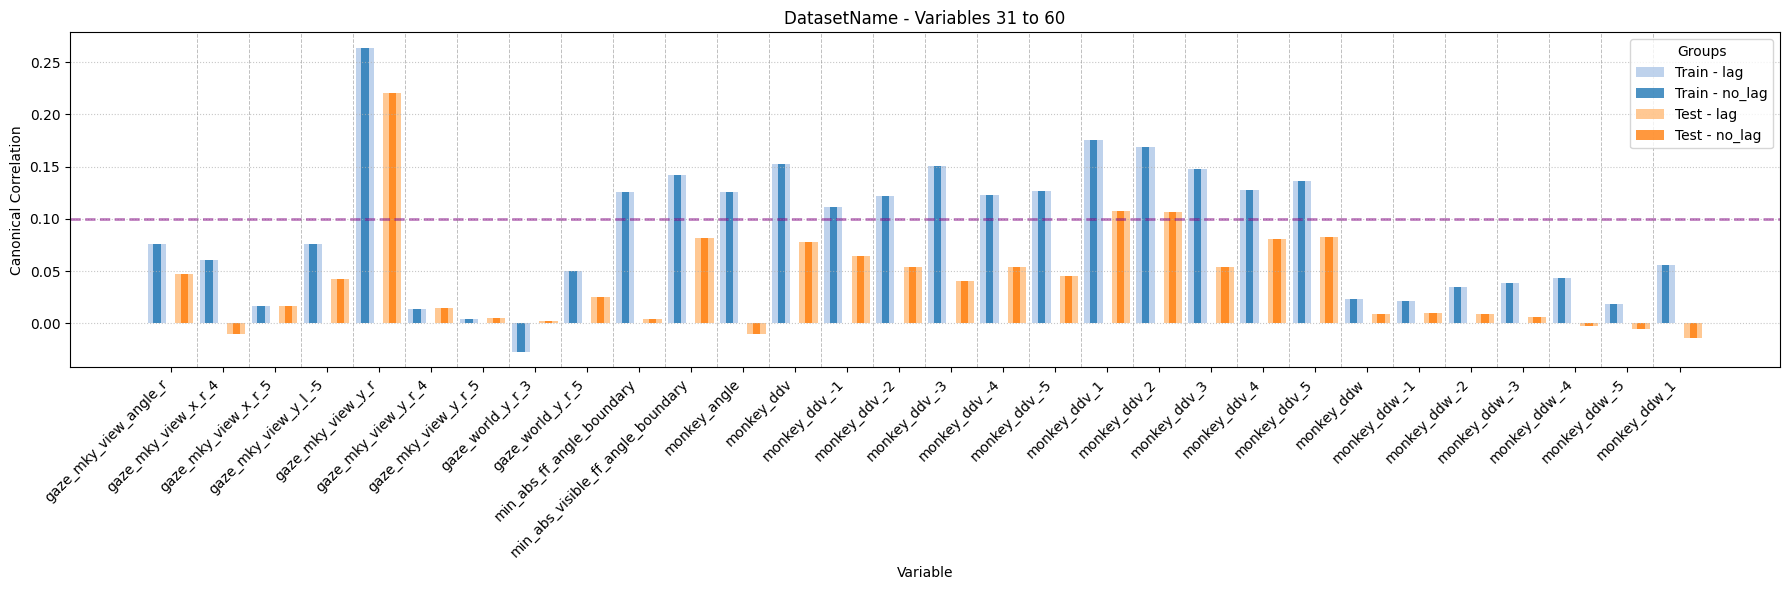

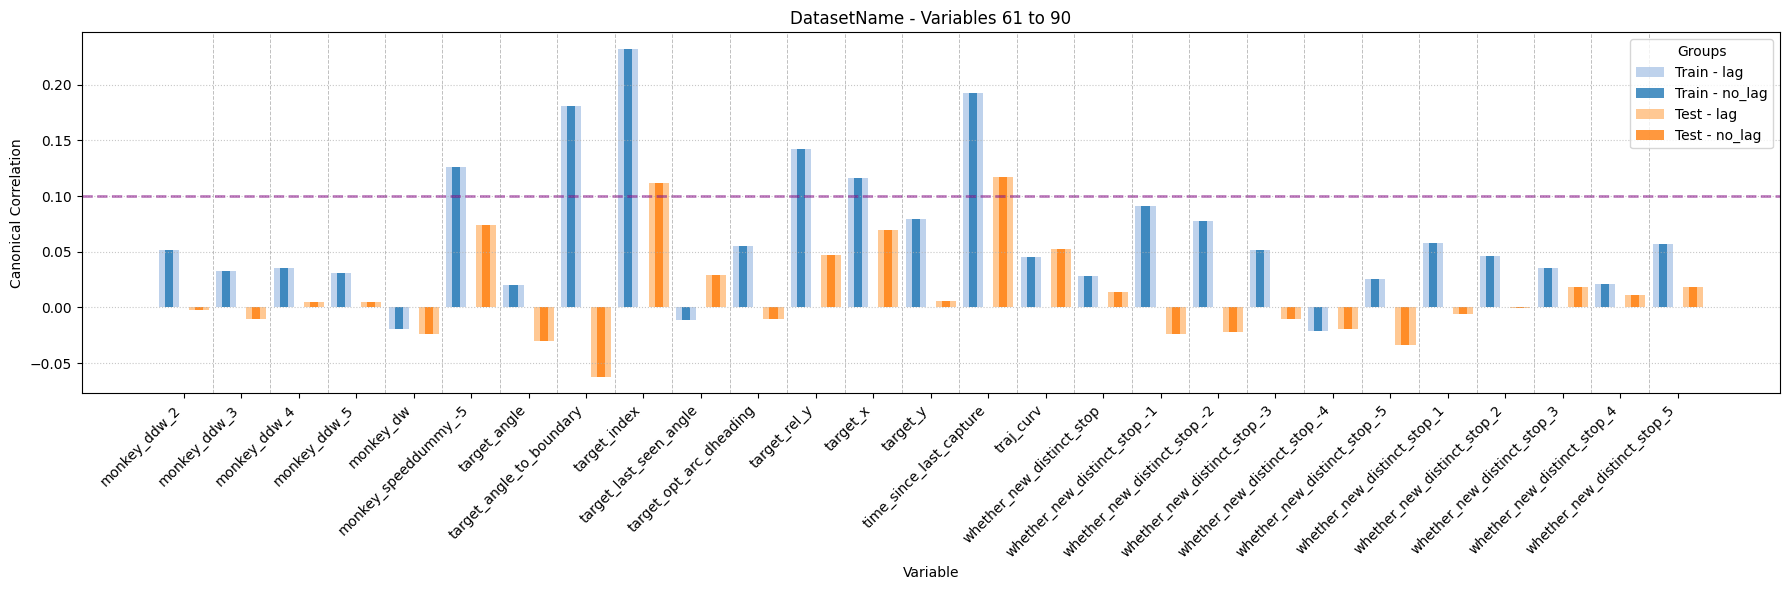

In [66]:
cca_lag_vs_no_lag_plotting.plot_cca_lag_vs_nolag_and_train_vs_test(combined_X2_df, 'DatasetName', mode='train_offset')


# Transform vars
e.g. use basis functions

In [75]:
cca_no_lag.X2_tf_df = transform_vars.transform_behav_data(cca_no_lag.X2)

cca_lags.X2_tf_df = transform_vars.transform_behav_data(cca_lags.X2)



Added smooth features: ['smooth_5_monkey_dw', 'smooth_7_monkey_dw']
Added gaussian_smooth features: ['gaussian_smooth_delta_distance', 'gaussian_smooth_monkey_ddv']
Added log features: ['log_time_since_last_capture']
Added poly features: ['poly_p0_5_monkey_ddv', 'poly_p0_5_target_rel_y', 'poly_p1_monkey_ddv', 'poly_p1_target_rel_y', 'poly_p2_monkey_ddv', 'poly_p2_target_rel_y', 'poly_p3_monkey_ddv', 'poly_p3_target_rel_y']
Added smooth features: ['smooth_5_monkey_dw', 'smooth_7_monkey_dw']
Added gaussian_smooth features: ['gaussian_smooth_delta_distance', 'gaussian_smooth_monkey_ddv']
Added log features: ['log_time_since_last_capture']
Added poly features: ['poly_p0_5_monkey_ddv', 'poly_p0_5_target_rel_y', 'poly_p1_monkey_ddv', 'poly_p1_target_rel_y', 'poly_p2_monkey_ddv', 'poly_p2_target_rel_y', 'poly_p3_monkey_ddv', 'poly_p3_target_rel_y']


In [85]:
cca_inst = cca_lags

X1_df = cca_inst.X1_sc_df
X2_df = cca_inst.X2_tf_df


## run k-fold CV

In [86]:
n_splits = 5
reg = 0.1
n_components = 10

# Canonical correlations
canon_corr_stats, cross_view_corr_stats = cca_cv_utils.crossvalidated_cca_analysis(X1_df, X2_df, n_components=n_components, reg=reg, n_splits=n_splits)


Training CCA, kernel = None, regularization = 0.1000, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


## plot

### cross view

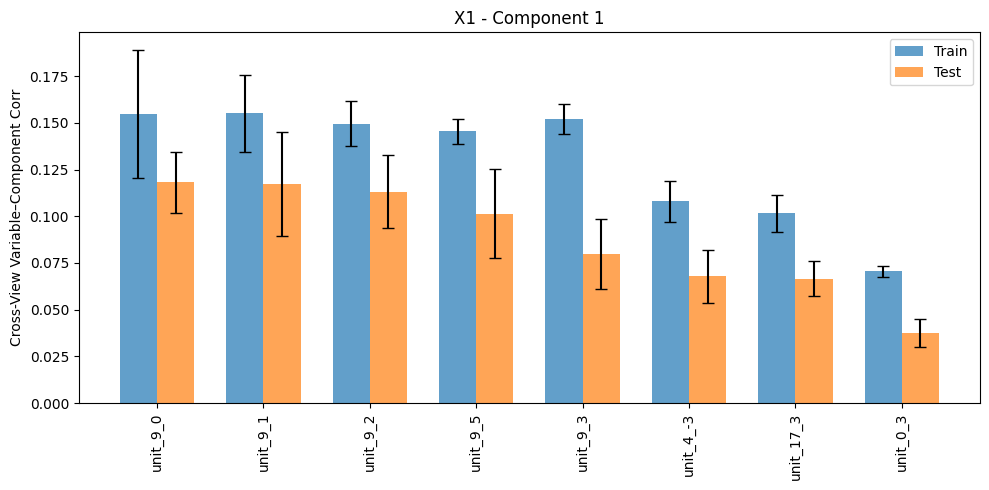

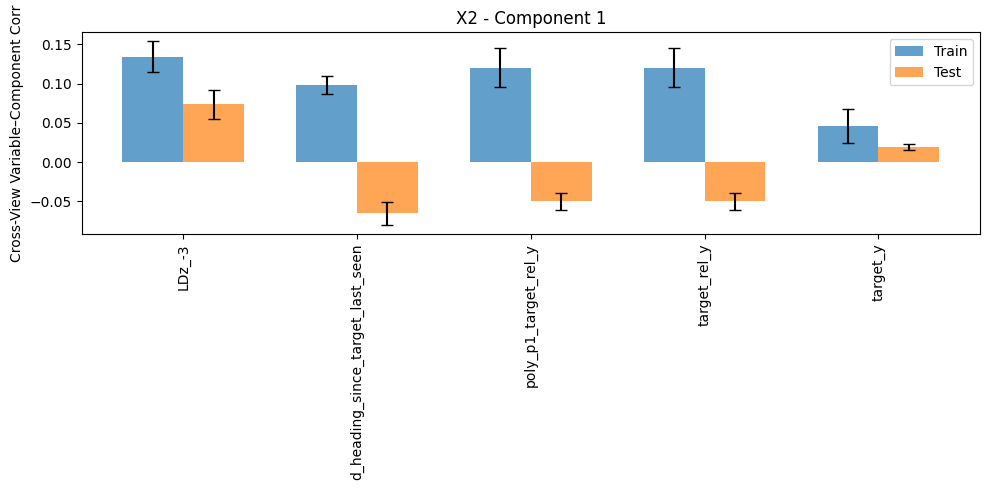

In [87]:
use_cross_view_corr = True
filter_significant = True
sort_by_significance = True
significance_threshold = 4

# Full plot
cca_cv_plotting.plot_cca_cv_results(cross_view_corr_stats, data_type='X1', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)
# Canonical correlation view
cca_cv_plotting.plot_cca_cv_results(cross_view_corr_stats, data_type='X2', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


### canon corr

In [90]:
use_cross_view_corr = False
filter_significant = True
sort_by_significance = True
significance_threshold = 4

# Full plot
cca_cv_plotting.plot_cca_cv_results(canon_corr_stats, data_type='X1', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)
# Canonical correlation view
cca_cv_plotting.plot_cca_cv_results(canon_corr_stats, data_type='X2', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


No significant X1 variables for component 1.
No significant X2 variables for component 1.


# Appendix

## thoughts: could you use neural data to decode target position?

what about 2nd target's position?
(can either use 1st target's decoder, or train and separate decoder for 2nd target)

also...try GPFA at some point 

## other potential transformers to use

In [ ]:
transformers = [
    ('identity', lambda x: x),
    ('log_signed', lambda x: np.log1p(np.abs(x)) * np.sign(x)),
    ('poly', lambda x: np.hstack([x**p for p in [1, 2, 3]])),
    ('sqrt_signed', lambda x: np.sqrt(np.abs(x)) * np.sign(x)),
    ('rank_gauss', rank_gauss_transform)  # optional custom
]


## check NA

In [60]:
general_utils.find_rows_with_na(cca_inst.X2_sc_df)


No NA values found in DataFrame


(Empty DataFrame
 Columns: [monkey_angle_0, monkey_dw_0, monkey_ddw_0, monkey_ddv_0, whether_new_distinct_stop_0, delta_distance_0, RDy_0, gaze_mky_view_y_r_0, gaze_mky_view_angle_r_0, eye_world_speed_0, num_visible_ff_0, min_abs_ff_angle_boundary_0, min_visible_ff_distance_0, min_abs_visible_ff_angle_boundary_0, catching_ff_0, any_ff_visible_0, time_since_last_capture_0, traj_curv_0, gaze_world_y_l_0, monkey_ddw_-1, monkey_ddv_-1, whether_new_distinct_stop_-1, delta_distance_-1, eye_world_speed_-1, catching_ff_-1, gaze_world_y_l_-1, monkey_ddw_1, monkey_ddv_1, whether_new_distinct_stop_1, delta_distance_1, gaze_mky_view_y_r_1, eye_world_speed_1, catching_ff_1, gaze_world_y_l_1, monkey_ddw_-2, monkey_ddv_-2, whether_new_distinct_stop_-2, delta_distance_-2, gaze_mky_view_x_r_-2, eye_world_speed_-2, catching_ff_-2, gaze_world_y_l_-2, monkey_ddw_2, monkey_ddv_2, whether_new_distinct_stop_2, delta_distance_2, gaze_mky_view_y_r_2, eye_world_speed_2, catching_ff_2, gaze_world_y_l_2, monkey_d

In [ ]:
general_utils.check_array_integrity(X_t, name="Array", top_n=10, verbose=True)


=== Checking: Array ===
Shape: (33125, 124)
❗ Total NaN values: 25808 (0.6283%)
Rows with ≥1 NaN: 21305
Cols with ≥1 NaN: 2
First 10 NaN positions (row, col): [(10, 115), (11, 115), (12, 115), (31, 115), (32, 115), (33, 115), (34, 115), (35, 115), (36, 115), (37, 115)]
Columns with most NaNs:
  Column 116: 16680 NaNs
  Column 115: 9128 NaNs
Rows with most NaNs:
  Row 13967: 2 NaNs
  Row 17428: 2 NaNs
  Row 23344: 2 NaNs
  Row 12360: 2 NaNs
  Row 28610: 2 NaNs
  Row 28611: 2 NaNs
  Row 28612: 2 NaNs
  Row 28613: 2 NaNs
  Row 28614: 2 NaNs
  Row 28615: 2 NaNs
✅ No infinite values found.

--- Summary statistics (excluding NaNs) ---
Min: -226.208235
Max: 350.576906
Mean: 0.021387
Std: 1.965530


## permutation test (later)

In [ ]:
import numpy as np
from tqdm import tqdm

n_permutations = 1000
component = 0  # which canonical component
n_features = X1.shape[1]

# Store observed loadings
observed_loadings = mean_X1_test[:, component]  # or use your preferred estimate

# Store null distributions
null_loadings = np.zeros((n_features, n_permutations))

for perm in tqdm(range(n_permutations)):
    # Shuffle rows of X1
    X1_perm = np.random.permutation(X1)
    # Fit CCA on permuted X1 and original X2
    cca2 = rcca.CCA(kernelcca=False, reg=0.1, numCC=nComponents)
    cca2.train([X1_perm, X2])
    U_perm = np.dot(X1_perm, cca2.ws[0])
    # Compute loadings for permuted data
    load_X1_perm = np.corrcoef(X1_perm.T, U_perm.T)[:n_features, n_features:]
    null_loadings[:, perm] = load_X1_perm[:, component]

# Compute two-sided p-values
p_values = np.mean(np.abs(null_loadings) >= np.abs(observed_loadings[:, None]), axis=1)

In [ ]:
import matplotlib.pyplot as plt

alpha = 0.05  # significance level
significant_mask = p_values < alpha

sig_means = observed_loadings[significant_mask]
sig_stds = std_X1_test[significant_mask, component]  # or use std from CV
sig_labels = np.array(x1_labels)[significant_mask]

plt.figure(figsize=(12, 5))
plt.bar(sig_labels, sig_means, yerr=sig_stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Mean Canonical Loading')
plt.title(f'Significant Canonical Loadings (p < {alpha})')
plt.tight_layout()
plt.show()